In [1]:
import os
import sys
from tqdm import tqdm
import pprint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap

from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F

sys.path.append('..')
from semilearn.core.utils import get_net_builder, get_dataset, over_write_args_from_file
from semilearn.algorithms.openmatch.openmatch import OpenMatchNet
from semilearn.algorithms.iomatch.iomatch import IOMatchNet

In [2]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--c', type=str, default='')

def load_model_at(step='best'):
    args.step = step
    if step == 'best':
        args.load_path = '/'.join(args.load_path.split('/')[1:-1]) + "/model_best.pth"
    if step == 'latest':
        #args.load_path = '/'.join(args.load_path.split('/')[:-1]) + "/model_at_{args.step}_step.pth"
        args.load_path = '/'.join(args.load_path.split('/')[:-1]) + "/latest_model.pth"
    else:
        args.load_path = '/'.join(args.load_path.split('/')[:-1]) + "/"+str(step)+"_model.pth"
        
    print(args.load_path)
    checkpoint_path = os.path.join(args.load_path)
    checkpoint = torch.load(checkpoint_path)
    load_model = checkpoint['ema_model']
    load_state_dict = {}
    for key, item in load_model.items():
        if key.startswith('module'):
            new_key = '.'.join(key.split('.')[1:])
            load_state_dict[new_key] = item
        else:
            load_state_dict[key] = item
    save_dir = '/'.join(checkpoint_path.split('/')[:-1])
    if step == 'best':
        args.save_dir = os.path.join(save_dir, f"model_best")
    else:
        args.save_dir = os.path.join(save_dir, f"step_{args.step}")
    os.makedirs(args.save_dir, exist_ok=True)
    _net_builder = get_net_builder(args.net, args.net_from_name)
    net = _net_builder(num_classes=args.num_classes)
    if args.algorithm == 'openmatch':
        net = OpenMatchNet(net, args.num_classes)
    elif args.algorithm == 'iomatch':
        net = IOMatchNet(net, args.num_classes)
    else:
        raise NotImplementedError
    keys = net.load_state_dict(load_state_dict)
    print(f'Model at step {args.step} loaded!')
    if torch.cuda.is_available():
        net.cuda()
    net.eval()
    
    return net

In [3]:
def evaluate_open(net, dataset_dict, num_classes, extended_test=False):
    full_loader = DataLoader(dataset_dict['test']['full'], batch_size=256, drop_last=False, shuffle=False, num_workers=1)
    if extended_test:
        extended_loader = DataLoader(dataset_dict['test']['extended'], batch_size=1024, drop_last=False, shuffle=False, num_workers=4)

    total_num = 0.0
    y_true_list = []
    y_pred_closed_list = []
    y_pred_ova_list = []
    
    results = {}
    
    with torch.no_grad():
        for data in tqdm(full_loader):
            x = data['x_lb']
            y = data['y_lb']

            if isinstance(x, dict):
                x = {k: v.cuda() for k, v in x.items()}
            else:
                x = x.cuda()
            y = y.cuda()

            num_batch = y.shape[0]
            total_num += num_batch
            
            out = net(x)
            logits, logits_open = out['logits'], out['logits_open']    
            pred_closed = logits.data.max(1)[1]
            
            probs = F.softmax(logits, 1)
            probs_open = F.softmax(logits_open.view(logits_open.size(0), 2, -1), 1)
            tmp_range = torch.arange(0, logits_open.size(0)).long().cuda()
            unk_score = probs_open[tmp_range, 0, pred_closed]
            pred_open = pred_closed.clone()
            pred_open[unk_score > 0.5] = num_classes

            y_true_list.extend(y.cpu().tolist())
            y_pred_closed_list.extend(pred_closed.cpu().tolist())
            y_pred_ova_list.extend(pred_open.cpu().tolist())

    y_true = np.array(y_true_list)

    closed_mask = y_true < num_classes
    open_mask = y_true >= num_classes
    y_true[open_mask] = num_classes

    y_pred_closed = np.array(y_pred_closed_list)
    y_pred_ova = np.array(y_pred_ova_list)

    # Closed Accuracy on Closed Test Data
    y_true_closed = y_true[closed_mask]
    y_pred_closed = y_pred_closed[closed_mask]
    closed_acc = accuracy_score(y_true_closed, y_pred_closed)
    closed_cfmat = confusion_matrix(y_true_closed, y_pred_closed, normalize='true')
    results['c_acc_c_p'] = closed_acc
    results['c_cfmat_c_p'] = closed_cfmat  

    # Open Accuracy on Full Test Data
    open_acc = balanced_accuracy_score(y_true, y_pred_ova)
    open_cfmat = confusion_matrix(y_true, y_pred_ova)
    results['o_acc_f_hq'] = open_acc  
    results['o_cfmat_f_hq'] = open_cfmat
        
    if extended_test:
        with torch.no_grad():
            for data in tqdm(extended_loader):
                x = data['x_lb']
                y = data['y_lb']

                if isinstance(x, dict):
                    x = {k: v.cuda() for k, v in x.items()}
                else:
                    x = x.cuda()
                y = y.cuda()

                num_batch = y.shape[0]
                total_num += num_batch

                out = net(x)
                logits, logits_open = out['logits'], out['logits_open']    
                pred_closed = logits.data.max(1)[1]

                probs = F.softmax(logits, 1)
                probs_open = F.softmax(logits_open.view(logits_open.size(0), 2, -1), 1)
                tmp_range = torch.arange(0, logits_open.size(0)).long().cuda()
                unk_score = probs_open[tmp_range, 0, pred_closed]
                pred_open = pred_closed.clone()
                pred_open[unk_score > 0.5] = num_classes

                y_true_list.extend(y.cpu().tolist())
                y_pred_closed_list.extend(pred_closed.cpu().tolist())
                y_pred_ova_list.extend(pred_open.cpu().tolist())
            
        y_true = np.array(y_true_list)

        open_mask = y_true >= num_classes
        y_true[open_mask] = num_classes
        y_pred_ova = np.array(y_pred_ova_list)
        
        # Open Accuracy on Extended Test Data
        open_acc = balanced_accuracy_score(y_true, y_pred_ova)
        open_cfmat = confusion_matrix(y_true, y_pred_ova, normalize='true')
        results['o_acc_e_hq'] = open_acc  
        results['o_cfmat_e_hq'] = open_cfmat
    
    print(f"#############################################################\n"
              f" Closed Accuracy on Closed Test Data: {results['c_acc_c_p'] * 100:.2f}\n"
              f" Open Accuracy on Full Test Data:     {results['o_acc_f_hq'] * 100:.2f}\n"
              #f" Open Accuracy on Extended Test Data: {results['o_acc_e_hq'] * 100:.2f}\n"
              f"#############################################################\n"
        )
    
    return results

In [4]:
def evaluate_io(args, net, dataset_dict, extended_test=False):
    """
    evaluation function for open-set SSL setting
    """

    full_loader = DataLoader(dataset_dict['train_ulb'], batch_size=256, drop_last=False, shuffle=False, num_workers=1)
    if extended_test:
        extended_loader = DataLoader(dataset_dict['test']['extended'], batch_size=1024, drop_last=False, shuffle=False, num_workers=4)

    total_num = 0.0
    y_true_list = []
    p_list = []
    pred_p_list = []
    pred_hat_q_list = []
    pred_q_list = []
    pred_q_prob_list=[]
    pred_hat_p_list = []

    with torch.no_grad():
        for data in tqdm(full_loader):
            x = data['x_ulb_w']
            y = data['y_ulb']
            #print('y',len(y),y)
            
            if isinstance(x, dict):
                x = {k: v.cuda() for k, v in x.items()}
            else:
                x = x.cuda()
            y = y.cuda()
            y_true_list.extend(y.cpu().tolist())

            num_batch = y.shape[0]
            total_num += num_batch

            outputs = net(x)
            logits = outputs['logits']
            logits_mb = outputs['logits_mb']
            logits_open = outputs['logits_open']

            # predictions p of closed-set classifier
            p = F.softmax(logits, 1)
            pred_p = p.data.max(1)[1]
            pred_p_list.extend(pred_p.cpu().tolist())

            # predictions hat_q from (closed-set + multi-binary) classifiers
            r = F.softmax(logits_mb.view(logits_mb.size(0), 2, -1), 1)
            tmp_range = torch.arange(0, logits_mb.size(0)).long().cuda()
            hat_q = torch.zeros((num_batch, args.num_classes + 1)).cuda()
            o_neg = r[tmp_range, 0, :]
            o_pos = r[tmp_range, 1, :]
            hat_q[:, :args.num_classes] = p * o_pos
            hat_q[:, args.num_classes] = torch.sum(p * o_neg, 1)
            pred_hat_q = hat_q.data.max(1)[1]
            pred_hat_q_list.extend(pred_hat_q.cpu().tolist())

            # predictions q of open-set classifier
            q = F.softmax(logits_open, 1)
            pred_q = q.data.max(1)[1]
            #print('p',p[0],'o_pos',o_pos[0])
            #print('q.data',q.data[0:10])
            #print('hatq.data',hat_q.data[0:10])
            #print('pred_q',pred_q)
            pred_q_prob = q.data
            pred_q_list.extend(pred_q.cpu().tolist())
            pred_q_prob_list.extend(pred_q_prob)

            # prediction hat_p of open-set classifier
            hat_p = q[:, :args.num_classes] / q[:, :args.num_classes].sum(1).unsqueeze(1)
            pred_hat_p = hat_p.data.max(1)[1]
            pred_hat_p_list.extend(pred_hat_p.cpu().tolist())

        y_true = np.array(y_true_list)
        #print('y_true',len(y_true),y_true)
        closed_mask = y_true < args.num_classes
        open_mask = y_true >= args.num_classes
        #y_true[open_mask] = args.num_classes
        #print('pred_q[censys_index]',pred_q[censys_index])

        pred_p = np.array(pred_p_list)
        pred_hat_p = np.array(pred_hat_p_list)
        pred_q = np.array(pred_q_list)
        pred_hat_q = np.array(pred_hat_q_list)
        
        # closed accuracy of p / hat_p on closed test data
        c_acc_c_p = accuracy_score(y_true[closed_mask], pred_p[closed_mask])
        c_acc_c_hp = accuracy_score(y_true[closed_mask], pred_hat_p[closed_mask])
        set_label =  ['adscore',
 'ahrefs',
 'arbor',
 'archive',
 'binaryedge',

 'criminalip',
 'cybergreen',

 'fofa',
 'internet_census',
 'internettl',
 'intrinsec',
 'ipip',
 'leakix',
 'onyphe',
 'quadmetrics',
 'quake',
 'rapid7',
 'rau',
 'shadowserver',
 'shodan',
 'stretchoid',
 'tum',
 'webRay',
 'x_threatbook',
 'zoomeye',
'driftnet(added in unknown)',
 'unknown',
 'censys(added in unknown)'                     ]
 
        c_cfmat_c_p = confusion_matrix(y_true[closed_mask], pred_p[closed_mask])
        
        
        
        print('y_true[closed_mask]',y_true[closed_mask])
        print('pred_hat_p[closed_mask]',pred_hat_p[closed_mask])
        c_cfmat_c_hp = confusion_matrix(y_true[closed_mask], pred_hat_p[closed_mask], normalize='true')
        np.set_printoptions(precision=3, suppress=True)

        # open accuracy of q / hat_q on full test data
        o_acc_f_q = balanced_accuracy_score(y_true, pred_q)
        o_acc_f_q_f = f1_score(y_true, pred_q,average='weighted')
        o_acc_f_hq = balanced_accuracy_score(y_true, pred_hat_q)
        o_acc_f_hq_f = f1_score(y_true, pred_hat_q,average='weighted')
        o_cfmat_f_q = confusion_matrix(y_true, pred_q)
        o_cfmat_f_hq = confusion_matrix(y_true, pred_hat_q)
        
   
        index_list=list(set(y_true)|set(pred_q))
        label_list=[]
        for item in index_list:
            label_list.append(set_label[item])

        y_true_arr = y_true.copy()
        value_to_delete = 26
        mask = y_true != value_to_delete
        filtered_y_true = y_true_arr[mask]
        filtered_pred_q = pred_q[mask]
        o_acc_f_q_filtered = balanced_accuracy_score(filtered_y_true, filtered_pred_q)
        y_true_arr[open_mask] = args.num_classes
        filtered_y_true_open_masked = y_true_arr[mask]
        o_acc_f_q_filtered_masked = balanced_accuracy_score(filtered_y_true_open_masked, filtered_pred_q)
        
        print('o_acc_f_q_filtered',o_acc_f_q_filtered)  
        print('o_acc_f_q_filtered_masked',o_acc_f_q_filtered_masked)


        o_acc_e_q = o_acc_e_hq = 0
        o_cfmat_e_q = None
        o_cfmat_e_hq = None

        if extended_test:
            unk_scores = []
            unk_scores_q = []
            for data in tqdm(extended_loader):
                x = data['x_lb']
                y = data['y_lb']

                if isinstance(x, dict):
                    x = {k: v.cuda() for k, v in x.items()}
                else:
                    x = x.cuda()
                y = y.cuda()
                y_true_list.extend(y.cpu().tolist())

                num_batch = y.shape[0]
                total_num += num_batch

                outputs = net(x)
                logits = outputs['logits']
                logits_mb = outputs['logits_mb']
                logits_open = outputs['logits_open']

                # predictions p of closed-set classifier
                p = F.softmax(logits, 1)
                pred_p = p.data.max(1)[1]
                pred_p_list.extend(pred_p.cpu().tolist())

                # predictions hat_q of (closed-set + multi-binary) classifiers
                r = F.softmax(logits_mb.view(logits_mb.size(0), 2, -1), 1)
                tmp_range = torch.arange(0, logits_mb.size(0)).long().cuda()
                hat_q = torch.zeros((num_batch, args.num_classes + 1)).cuda()
                o_neg = r[tmp_range, 0, :]
                o_pos = r[tmp_range, 1, :]
                unk_score = torch.sum(p * o_neg, 1)
                hat_q[:, :args.num_classes] = p * o_pos
                hat_q[:, args.num_classes] = torch.sum(p * o_neg, 1)
                pred_hat_q = hat_q.data.max(1)[1]
                pred_hat_q_list.extend(pred_hat_q.cpu().tolist())

                # predictions q of open-set classifier
                q = F.softmax(logits_open, 1)
                pred_q = q.data.max(1)[1]
                pred_q_list.extend(pred_q.cpu().tolist())

                # prediction hat_p of open-set classifier
                hat_p = q[:, :args.num_classes] / q[:, :args.num_classes].sum(1).unsqueeze(1)
                pred_hat_p = hat_p.data.max(1)[1]
                pred_hat_p_list.extend(pred_hat_p.cpu().tolist())

            y_true = np.array(y_true_list)
            open_mask = y_true >= args.num_classes
            y_true[open_mask] = args.num_classes

            pred_q = np.array(pred_q_list)
            pred_hat_q = np.array(pred_hat_q_list)

            # open accuracy of q / hat_q on extended test data
            o_acc_e_q = balanced_accuracy_score(y_true, pred_q)
            o_acc_e_hq = balanced_accuracy_score(y_true, pred_hat_q)
            o_cfmat_e_q = confusion_matrix(y_true, pred_q, normalize='true')
            o_cfmat_e_hq = confusion_matrix(y_true, pred_hat_q, normalize='true')

        eval_dict = {'c_acc_c_p': c_acc_c_p, 'c_acc_c_hp': c_acc_c_hp,
                     'o_acc_f_q': o_acc_f_q, 'o_acc_f_hq': o_acc_f_hq,
                     'o_acc_e_q': o_acc_e_q, 'o_acc_e_hq': o_acc_e_hq,
                     'c_cfmat_c_p': c_cfmat_c_p, 'c_cfmat_c_hp': c_cfmat_c_hp,
                     'o_cfmat_f_q': o_cfmat_f_q, 'o_cfmat_f_hq': o_cfmat_f_hq,
                     'o_cfmat_e_q': o_cfmat_e_q, 'o_cfmat_e_hq': o_cfmat_e_hq,
                     'pred_q_prob_list':pred_q_prob_list,
                     'o_acc_f_q_f':o_acc_f_q_f,
                     'label_list':label_list,
                     'o_acc_f_q_filtered':o_acc_f_q_filtered,
                     'pred_q':pred_q,
                     'pred_p':pred_p,
                     'y_true':y_true
                    }
        print('fscore',o_acc_f_q_f,'f_hq',o_acc_f_hq_f)
        print(f"#############################################################\n"
              f" Closed Accuracy on Closed Test Data (p / hp): {c_acc_c_p * 100:.2f} / {c_acc_c_hp * 100:.2f}\n"
              f" Open Accuracy on Full Test Data (q / hq):     {o_acc_f_q * 100:.2f} / {o_acc_f_hq * 100:.2f}\n"
              f" Open Accuracy on Extended Test Data (q / hq): {o_acc_e_q * 100:.2f} / {o_acc_e_hq * 100:.2f}\n"
              f"#############################################################\n"
            )

        return eval_dict

[('2024-12-10', '2024-12-17'), ('2024-12-17', '2024-12-24'), ('2024-12-24', '2024-12-31'), ('2024-12-31', '2025-01-07'), ('2025-01-07', '2025-01-14'), ('2025-01-14', '2025-01-21'), ('2025-01-21', '2025-01-28'), ('2025-01-28', '2025-02-04'), ('2025-02-04', '2025-02-11'), ('2025-02-11', '2025-02-18'), ('2025-02-18', '2025-02-25'), ('2025-02-25', '2025-03-04'), ('2025-03-04', '2025-03-11')]
start_date_str 2024-12-10 end_date_str 2024-12-17
rm data/selfdeploy_24_25_1week_http_openset/labeled_idx/*
0
dataset_name selfdeploy_24_25_1week
data_dir data/cifar10


/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


num_labels 2500 num_classes 25 this mode use all samples
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]
idx_new [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]
samples_per_class 100 idx [264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 283 284 285 286 287 288 289]
idx_new [264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 283 284 285 286 287 288 289]
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx [369 370 371 372 373 374 375 376 377 378 379 380 381 382]
idx_new [369 370 371 372 373 374 375 376 377 378 379 380 381 382]
samples_per_class 100 idx [383 384 385 386 387 388 389 390 391 392 393 394 395 396 

100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 41.89it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


y_true[closed_mask] [ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11
 11 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20]
pred_hat_p[closed_mask] [ 7  7 11  7  7 11  7 11  7  7 11  7  7

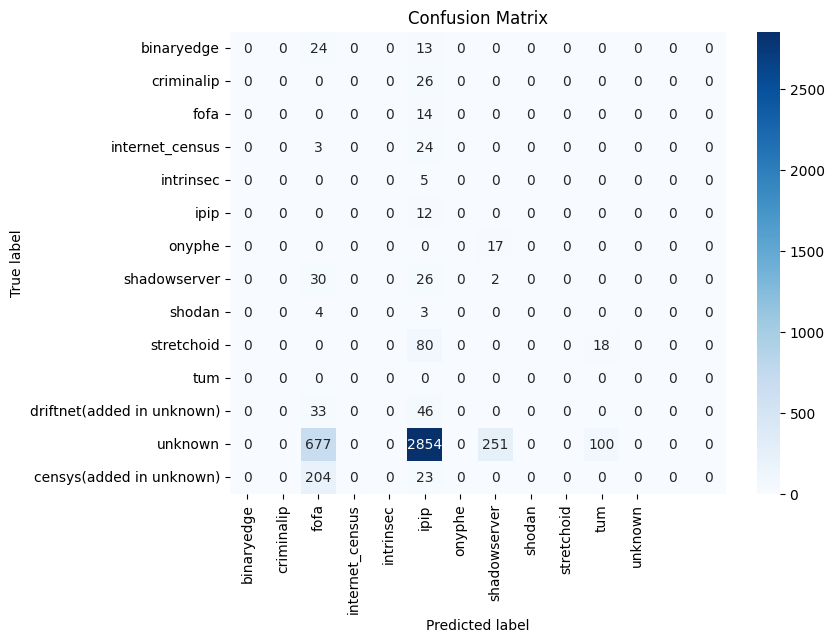

      prediction               ip  groundtruth            timestamp
0              7     45.79.205.89            4  2024-12-11 06:00:57
1              7     45.79.205.89            4  2024-12-11 06:00:58
2             11     45.79.205.89            4  2024-12-11 06:01:14
3              7    138.68.25.139            4  2024-12-11 06:05:10
4              7    138.68.25.139            4  2024-12-11 06:05:12
...          ...              ...          ...                  ...
4484          21   46.101.154.129           26  2024-12-16 15:50:03
4485          11  178.215.238.105           26  2024-12-16 15:50:08
4486          11  178.215.238.105           26  2024-12-16 15:53:31
4487          11  129.211.166.134           26  2024-12-16 15:54:44
4488          11     3.12.160.166           26  2024-12-16 15:59:58

[4489 rows x 4 columns]
Earliest time: 2024-12-10 16:00:00
Latest time: 2024-12-17 16:00:00
2024-12-10 16:00:00 2024-12-17 16:00:00
Segment 1 (2024-12-10 16:00:00 to 2024-12-17 16:00:

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 470
dataset_data (470, 32, 32, 3)
dataset_data (6312, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7ff3e64c4700> lb_dset 470
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_http_ep2_bs32/399_model.pth
Model at step 399 loaded!


100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 39.42it/s]


y_true[closed_mask] [ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  9  9  9 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 

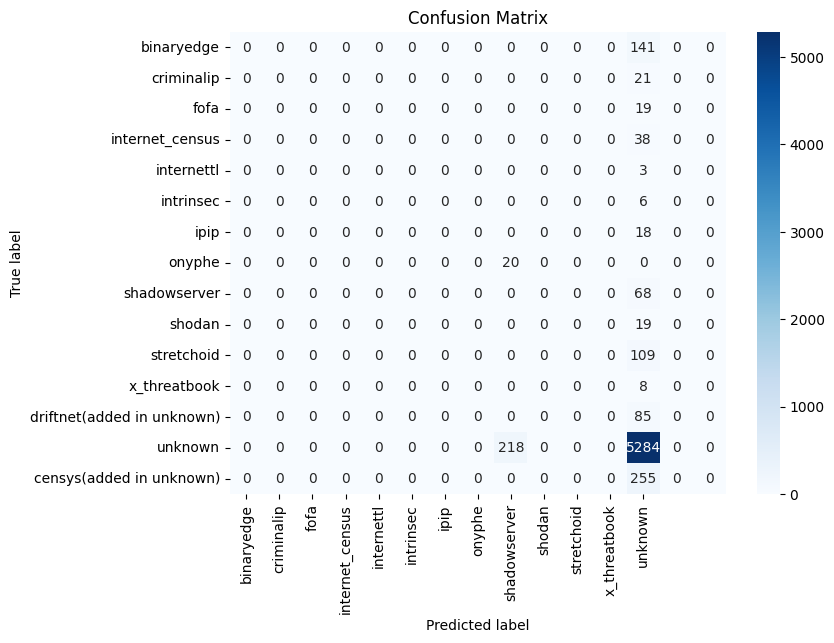

      prediction               ip  groundtruth            timestamp
0             25   173.230.149.27            4  2024-12-17 10:57:54
1             25   173.230.149.27            4  2024-12-17 10:57:56
2             25   173.230.149.27            4  2024-12-17 10:58:12
3             25    23.239.16.235            4  2024-12-17 12:34:39
4             25    23.239.16.235            4  2024-12-17 12:34:41
...          ...              ...          ...                  ...
6307          25  165.154.182.174           23  2024-12-17 23:25:37
6308          25  165.154.182.174           23  2024-12-17 23:29:47
6309          25  165.154.182.174           23  2024-12-21 20:55:08
6310          25  165.154.182.174           23  2024-12-21 20:56:45
6311          25  165.154.182.174           23  2024-12-21 20:59:23

[6312 rows x 4 columns]
Earliest time: 2024-12-17 16:00:00
Latest time: 2024-12-24 16:00:00
2024-12-17 16:00:00 2024-12-24 16:00:00
Segment 1 (2024-12-17 16:00:00 to 2024-12-24 16:00:

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 393
dataset_data (393, 32, 32, 3)
dataset_data (8531, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7ff3e6092e50> lb_dset 393
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_http_ep2_bs32/599_model.pth
Model at step 599 loaded!


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 50.10it/s]


y_true[closed_mask] [ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  9  9 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 13 13 13 13 13 13 13 13 13 13 13 13 13 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 19 19 19 19 19 19
 19 19 19 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 

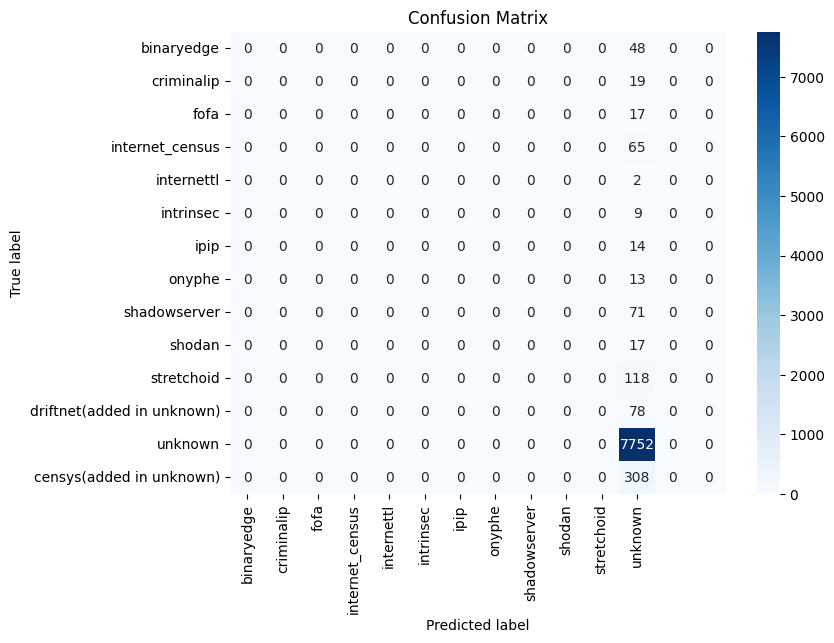

      prediction               ip  groundtruth            timestamp
0             25    64.227.87.245            4  2024-12-24 18:10:51
1             25    64.227.87.245            4  2024-12-24 18:10:54
2             25  167.172.140.251            4  2024-12-24 18:12:10
3             25  167.172.140.251            4  2024-12-24 18:12:12
4             25  167.172.140.251            4  2024-12-24 18:12:19
...          ...              ...          ...                  ...
8526          25    45.207.223.44           26  2024-12-30 15:57:44
8527          25    45.207.223.44           26  2024-12-30 15:57:56
8528          25    45.207.223.44           26  2024-12-30 15:58:10
8529          25    45.207.223.44           26  2024-12-30 15:58:23
8530          25   118.193.57.218           26  2024-12-30 15:59:06

[8531 rows x 4 columns]
Earliest time: 2024-12-24 16:00:00
Latest time: 2024-12-31 16:00:00
2024-12-24 16:00:00 2024-12-31 16:00:00
Segment 1 (2024-12-24 16:00:00 to 2024-12-31 16:00:

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step 799 loaded!


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 26.45it/s]


y_true[closed_mask] [ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  9  9  9  9 10 10 10 10 10 10 10 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 15 15 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 20 20 20 20 20 

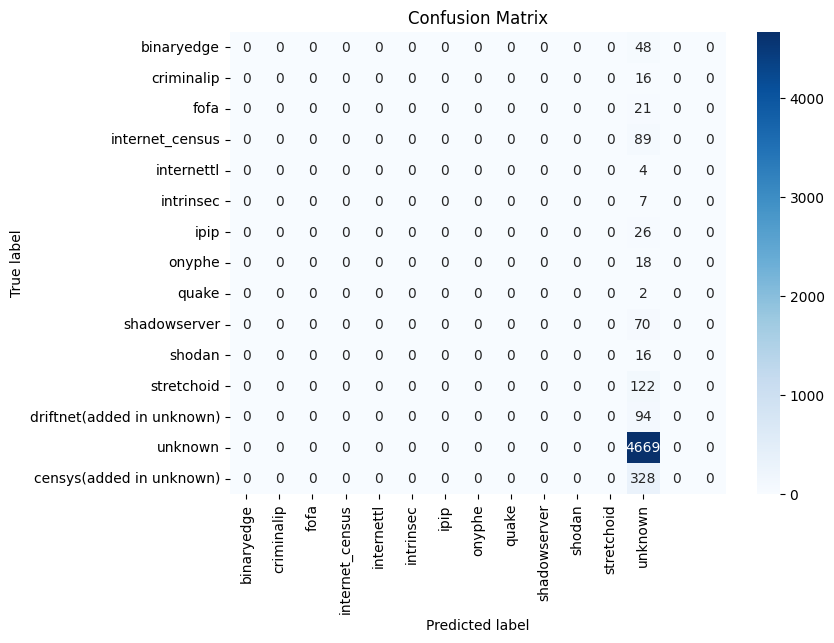

      prediction               ip  groundtruth            timestamp
0             25   159.223.152.50            4  2025-01-01 04:29:20
1             25   159.223.152.50            4  2025-01-01 04:29:22
2             25   159.223.152.50            4  2025-01-01 04:29:37
3             25    167.99.109.78            4  2025-01-01 06:22:59
4             25    167.99.109.78            4  2025-01-01 06:23:00
...          ...              ...          ...                  ...
5525          25    193.34.212.75           26  2025-01-06 15:54:11
5526          25      45.93.9.197           26  2025-01-06 15:54:17
5527          25  157.245.104.121           26  2025-01-06 15:55:18
5528          25  157.245.104.121           26  2025-01-06 15:56:17
5529          25     68.235.46.38           26  2025-01-06 15:58:37

[5530 rows x 4 columns]
Earliest time: 2024-12-31 16:00:00
Latest time: 2025-01-07 16:00:00
2024-12-31 16:00:00 2025-01-07 16:00:00
Segment 1 (2024-12-31 16:00:00 to 2025-01-07 16:00:

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 572
dataset_data (572, 32, 32, 3)
dataset_data (6763, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7ff3e6198430> lb_dset 572
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_http_ep2_bs32/999_model.pth
Model at step 999 loaded!


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 47.09it/s]


y_true[closed_mask] [ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9
  9  9  9  9  9 10 10 10 10 10 

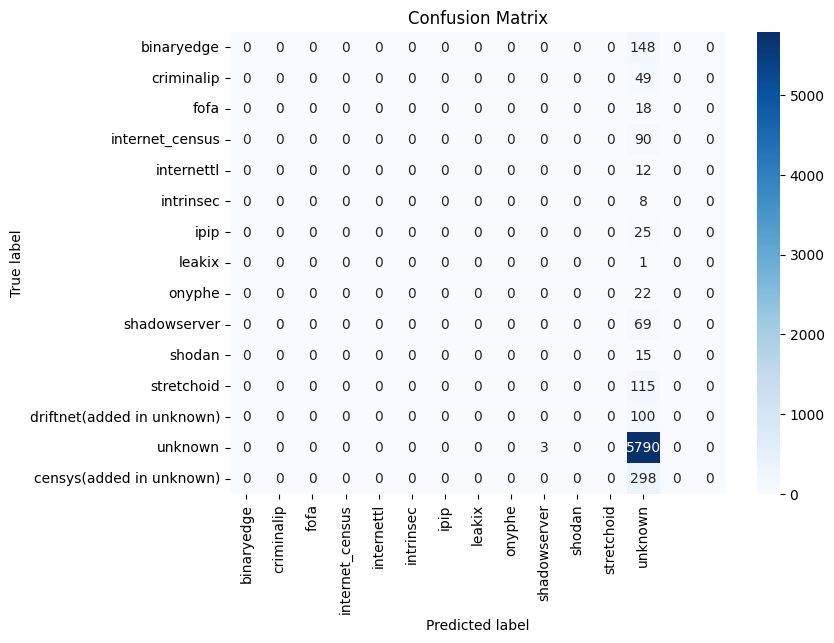

      prediction               ip  groundtruth            timestamp
0             25    45.56.101.233            4  2025-01-07 05:19:03
1             25  147.182.141.103            4  2025-01-07 05:19:08
2             25      45.79.13.34            4  2025-01-07 05:19:09
3             25    64.227.87.245            4  2025-01-07 05:19:09
4             25    64.227.87.245            4  2025-01-07 05:19:09
...          ...              ...          ...                  ...
6758          25    5.181.190.248           26  2025-01-13 15:46:41
6759          25    104.131.82.44           26  2025-01-13 15:48:10
6760          25   107.172.178.67           26  2025-01-13 15:48:25
6761          25   78.153.140.203           26  2025-01-13 15:53:00
6762          25    193.34.212.75           26  2025-01-13 15:58:53

[6763 rows x 4 columns]
Earliest time: 2025-01-07 16:00:00
Latest time: 2025-01-14 16:00:00
2025-01-07 16:00:00 2025-01-14 16:00:00
Segment 1 (2025-01-07 16:00:00 to 2025-01-14 16:00:

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step 1199 loaded!


100%|███████████████████████████████████████████| 23/23 [00:00<00:00, 38.60it/s]


y_true[closed_mask] [ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9 10 10 10 10
 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 19 19 19 19 19 

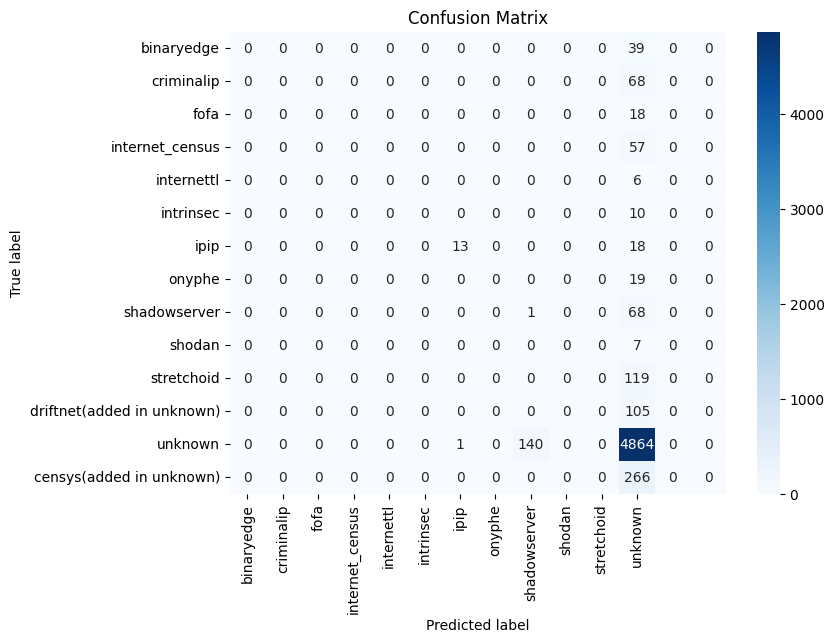

      prediction               ip  groundtruth            timestamp
0             25  206.189.164.156            4  2025-01-16 06:17:21
1             25  206.189.164.156            4  2025-01-16 06:17:21
2             25  206.189.164.156            4  2025-01-16 06:17:24
3             25    159.223.139.9            4  2025-01-16 09:43:33
4             25    159.223.139.9            4  2025-01-16 09:43:35
...          ...              ...          ...                  ...
5814          25      43.163.8.36           26  2025-01-20 15:45:24
5815          25  185.189.182.234           26  2025-01-20 15:47:45
5816          25  185.196.220.253           26  2025-01-20 15:53:49
5817          25     146.19.24.18           26  2025-01-20 15:54:38
5818          25    58.187.92.176           26  2025-01-20 15:55:31

[5819 rows x 4 columns]
Earliest time: 2025-01-14 16:00:00
Latest time: 2025-01-21 16:00:00
2025-01-14 16:00:00 2025-01-21 16:00:00
Segment 1 (2025-01-14 16:00:00 to 2025-01-21 16:00:

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 490
dataset_data (490, 32, 32, 3)
dataset_data (6658, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7ff438657610> lb_dset 490
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_http_ep2_bs32/1399_model.pth
Model at step 1399 loaded!


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 46.99it/s]


y_true[closed_mask] [ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  9  9  9  9  9 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 

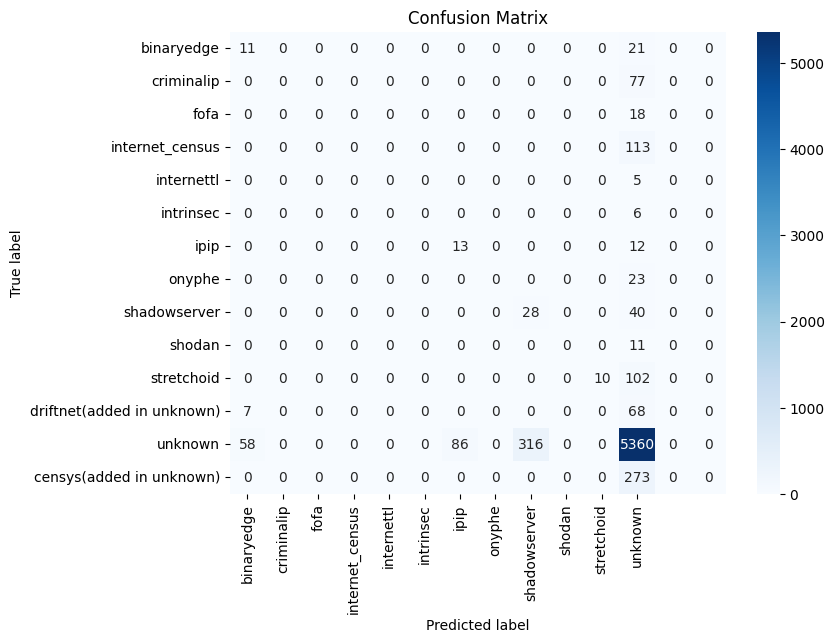

      prediction              ip  groundtruth            timestamp
0             25  104.248.69.239            4  2025-01-22 01:44:11
1             25  104.248.69.239            4  2025-01-22 01:44:13
2              4  104.248.69.239            4  2025-01-22 01:44:31
3             25    45.56.94.191            4  2025-01-22 04:17:09
4             25    45.56.94.191            4  2025-01-22 04:17:11
...          ...             ...          ...                  ...
6653          25   170.64.152.21           26  2025-01-27 15:41:00
6654          25   95.214.55.132           26  2025-01-27 15:47:22
6655          25    111.7.96.149           26  2025-01-27 15:49:52
6656          18   3.137.207.247           26  2025-01-27 15:58:34
6657          18   3.137.207.247           26  2025-01-27 15:58:50

[6658 rows x 4 columns]
Earliest time: 2025-01-21 16:00:00
Latest time: 2025-01-28 16:00:00
2025-01-21 16:00:00 2025-01-28 16:00:00
Segment 1 (2025-01-21 16:00:00 to 2025-01-28 16:00:00):
      p

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 527
dataset_data (527, 32, 32, 3)
dataset_data (7031, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7ff3e627ccd0> lb_dset 527
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_http_ep2_bs32/1599_model.pth
Model at step 1599 loaded!


100%|███████████████████████████████████████████| 28/28 [00:00<00:00, 47.12it/s]


y_true[closed_mask] [ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  9  9  9  9  9 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 

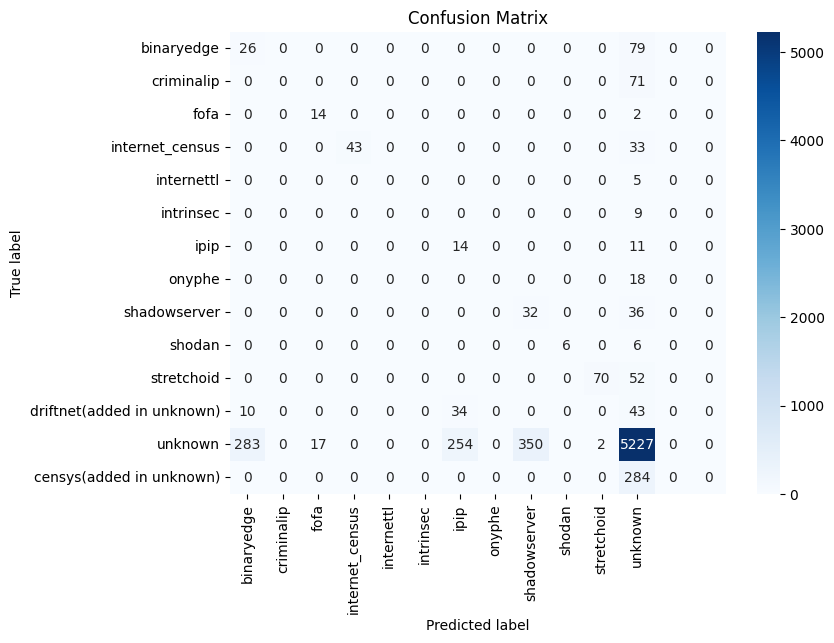

      prediction               ip  groundtruth            timestamp
0             25    64.227.87.132            4  2025-01-28 05:57:32
1             25    64.227.87.132            4  2025-01-28 05:57:34
2              4    64.227.87.132            4  2025-01-28 05:57:51
3             25   64.225.113.174            4  2025-01-28 06:04:35
4             25   64.225.113.174            4  2025-01-28 06:04:36
...          ...              ...          ...                  ...
7026          25     76.244.18.43           26  2025-02-03 15:32:54
7027          25  109.205.213.198           26  2025-02-03 15:37:36
7028          25    36.91.144.195           26  2025-02-03 15:39:26
7029          25   205.210.31.146           26  2025-02-03 15:58:55
7030          25   141.255.166.90           26  2025-02-03 15:59:20

[7031 rows x 4 columns]
Earliest time: 2025-01-28 16:00:00
Latest time: 2025-02-04 16:00:00
2025-01-28 16:00:00 2025-02-04 16:00:00
Segment 1 (2025-01-28 16:00:00 to 2025-02-04 16:00:

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 490
dataset_data (490, 32, 32, 3)
dataset_data (6106, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7ff3e61ca220> lb_dset 490
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_http_ep2_bs32/1799_model.pth
Model at step 1799 loaded!


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 44.67it/s]


y_true[closed_mask] [ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9 10 10
 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 

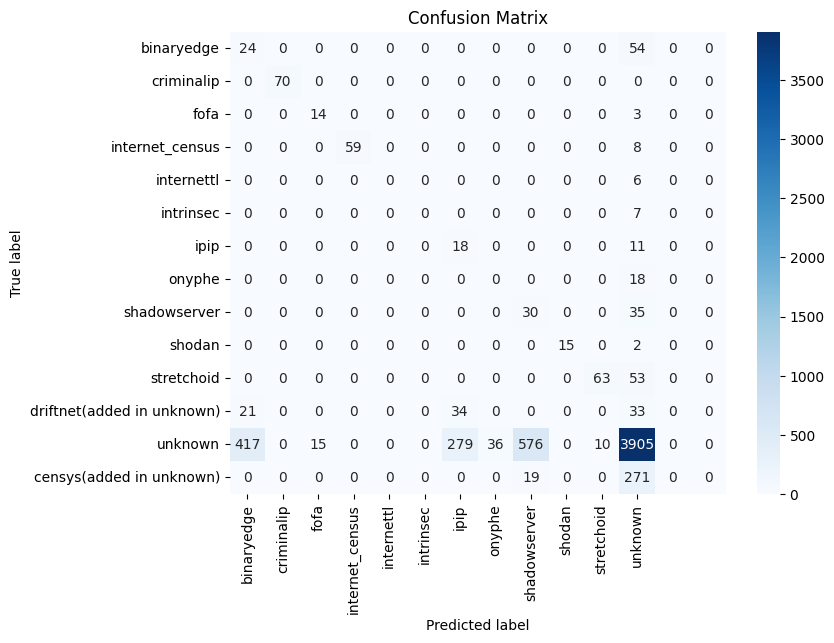

      prediction               ip  groundtruth            timestamp
0             25  143.110.202.193            4  2025-02-03 21:46:21
1             25  143.110.202.193            4  2025-02-03 21:46:21
2             25  143.110.202.193            4  2025-02-03 21:46:21
3             25  143.110.202.193            4  2025-02-03 21:46:21
4             25  143.110.202.193            4  2025-02-03 21:46:21
...          ...              ...          ...                  ...
6101          25     193.68.89.10           26  2025-02-10 15:49:21
6102          25     193.68.89.10           26  2025-02-10 15:53:23
6103          25     193.68.89.10           26  2025-02-10 15:55:47
6104          25   159.203.139.98           26  2025-02-10 15:59:10
6105          25   205.210.31.130           26  2025-02-10 15:59:30

[6106 rows x 4 columns]
Earliest time: 2025-02-04 16:00:00
Latest time: 2025-02-11 16:00:00
2025-02-04 16:00:00 2025-02-11 16:00:00
Segment 1 (2025-02-04 16:00:00 to 2025-02-11 16:00:

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 454
dataset_data (454, 32, 32, 3)
dataset_data (6959, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7ff3e64cc0a0> lb_dset 454
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_http_ep2_bs32/1999_model.pth
Model at step 1999 loaded!


100%|███████████████████████████████████████████| 28/28 [00:00<00:00, 46.74it/s]


y_true[closed_mask] [ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9
  9  9 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 15 15 15 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 

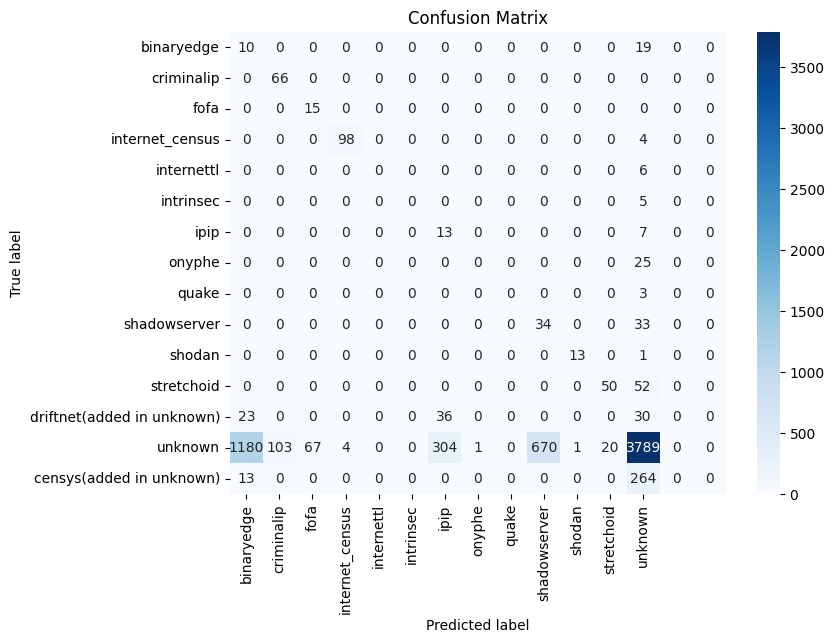

      prediction               ip  groundtruth            timestamp
0             25     68.183.27.94            4  2025-02-10 16:34:32
1             25     68.183.27.94            4  2025-02-10 16:34:34
2              4     68.183.27.94            4  2025-02-10 16:34:51
3             25    167.99.107.21            4  2025-02-12 12:53:33
4             25    167.99.107.21            4  2025-02-12 12:53:35
...          ...              ...          ...                  ...
6954          25     45.148.10.90           26  2025-02-17 15:45:16
6955          25   122.117.62.232           26  2025-02-17 15:50:57
6956          25     92.255.57.58           26  2025-02-17 15:51:28
6957          25     92.255.57.58           26  2025-02-17 15:54:18
6958          25  220.132.194.158           26  2025-02-17 15:58:48

[6959 rows x 4 columns]
Earliest time: 2025-02-11 16:00:00
Latest time: 2025-02-18 16:00:00
2025-02-11 16:00:00 2025-02-18 16:00:00
Segment 1 (2025-02-11 16:00:00 to 2025-02-18 16:00:

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 390
dataset_data (390, 32, 32, 3)
dataset_data (5808, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7ff278756bb0> lb_dset 390
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_http_ep2_bs32/2199_model.pth
Model at step 2199 loaded!


100%|███████████████████████████████████████████| 23/23 [00:00<00:00, 44.16it/s]


y_true[closed_mask] [ 4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9
  9  9  9 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 15 15 15 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 

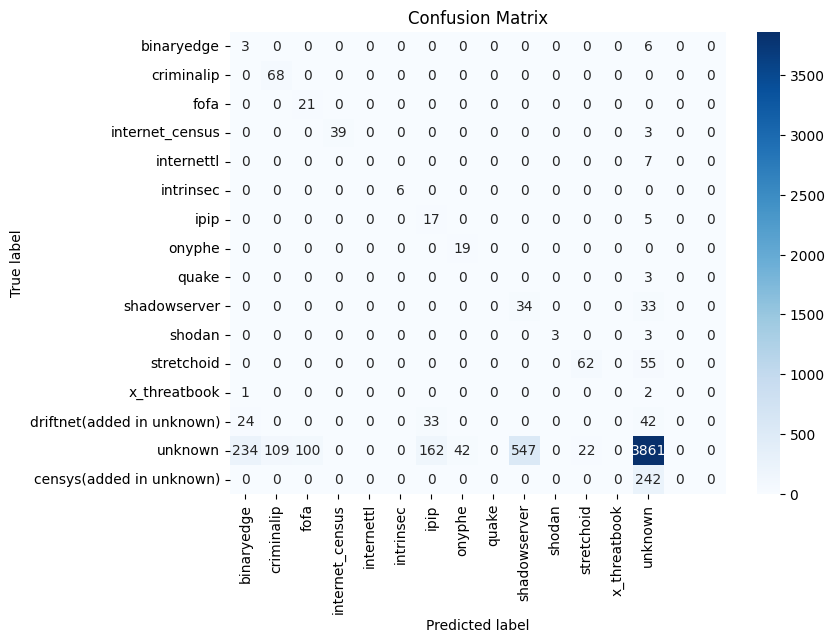

      prediction              ip  groundtruth            timestamp
0             25  142.93.199.199            4  2025-02-18 12:26:02
1             25  142.93.199.199            4  2025-02-18 12:26:03
2              4  142.93.199.199            4  2025-02-18 12:26:19
3             25    142.93.24.78            4  2025-02-18 12:28:36
4             25    142.93.24.78            4  2025-02-18 12:28:37
...          ...             ...          ...                  ...
5803          25    45.148.10.90           26  2025-02-24 15:56:47
5804          25  45.144.212.139           26  2025-02-24 15:59:24
5805          25  152.32.187.105           23  2025-02-24 15:43:11
5806          25  152.32.187.105           23  2025-02-24 15:44:46
5807           4  152.32.187.105           23  2025-02-24 15:47:14

[5808 rows x 4 columns]
Earliest time: 2025-02-18 16:00:00
Latest time: 2025-02-25 16:00:00
2025-02-18 16:00:00 2025-02-25 16:00:00
Segment 1 (2025-02-18 16:00:00 to 2025-02-25 16:00:00):
      p

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 438
dataset_data (438, 32, 32, 3)
dataset_data (8487, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7ff405bc6040> lb_dset 438
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_http_ep2_bs32/2399_model.pth
Model at step 2399 loaded!


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 49.91it/s]


y_true[closed_mask] [ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  9  9  9  9  9  9 10 10 10 10 10 10 10 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 13 13 13 13 13 13 13 13 13 13 13 13 13
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 

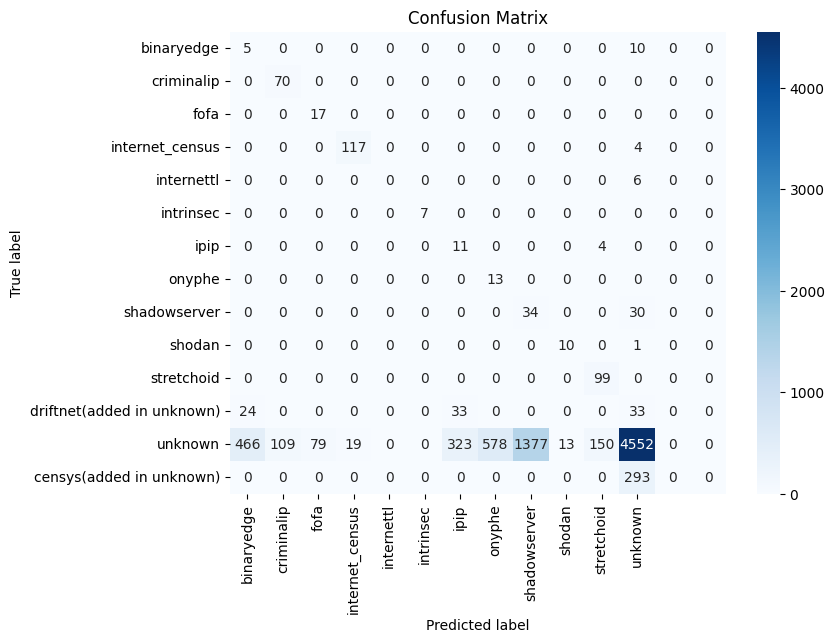

      prediction              ip  groundtruth            timestamp
0             25  96.126.112.135            4  2025-03-02 04:48:28
1             25  96.126.112.135            4  2025-03-02 04:48:29
2              4  96.126.112.135            4  2025-03-02 04:48:46
3             25  165.227.11.236            4  2025-03-02 07:56:11
4             25  165.227.11.236            4  2025-03-02 07:56:13
...          ...             ...          ...                  ...
8482          25    46.19.143.26           26  2025-03-03 15:55:46
8483          25  45.144.212.139           26  2025-03-03 15:57:18
8484          25   196.251.72.73           26  2025-03-03 15:57:50
8485          25    193.68.89.10           26  2025-03-03 15:57:59
8486          25  196.251.85.250           26  2025-03-03 15:58:57

[8487 rows x 4 columns]
Earliest time: 2025-02-25 16:00:00
Latest time: 2025-03-04 16:00:00
2025-02-25 16:00:00 2025-03-04 16:00:00
Segment 1 (2025-02-25 16:00:00 to 2025-03-04 16:00:00):
      p

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 485
dataset_data (485, 32, 32, 3)
dataset_data (6685, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7ff405bed3d0> lb_dset 485
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_http_ep2_bs32/2599_model.pth
Model at step 2599 loaded!


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 46.89it/s]


y_true[closed_mask] [ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9 10 10 10 10 10 10 10
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 15 15 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 

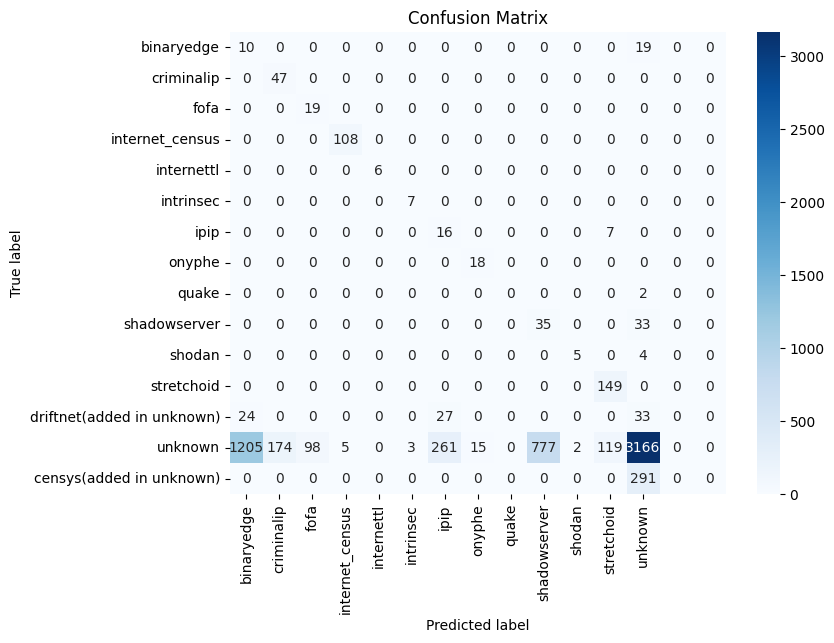

      prediction              ip  groundtruth            timestamp
0             25    45.79.111.57            4  2025-03-05 04:36:33
1             25    45.79.111.57            4  2025-03-05 04:36:35
2              4    45.79.111.57            4  2025-03-05 04:36:51
3             25  104.248.235.61            4  2025-03-05 04:46:45
4             25  104.248.235.61            4  2025-03-05 04:46:46
...          ...             ...          ...                  ...
6680          25  220.123.229.17           26  2025-03-10 15:49:59
6681          25    118.26.36.18           26  2025-03-10 15:55:47
6682          25    118.26.36.18           26  2025-03-10 15:57:02
6683           5  198.235.24.135           26  2025-03-10 15:57:42
6684           4    118.26.36.18           26  2025-03-10 15:59:33

[6685 rows x 4 columns]
Earliest time: 2025-03-04 16:00:00
Latest time: 2025-03-11 16:00:00
2025-03-04 16:00:00 2025-03-11 16:00:00
Segment 1 (2025-03-04 16:00:00 to 2025-03-11 16:00:00):
      p

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 632
dataset_data (632, 32, 32, 3)
dataset_data (3624, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7ff418605e80> lb_dset 632
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_tls_ep2_bs32/199_model.pth
Model at step 199 loaded!


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 39.15it/s]


y_true[closed_mask] [ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  9 10 11 11 11 11 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 19 19 19 19 19 19 19 19 19
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 

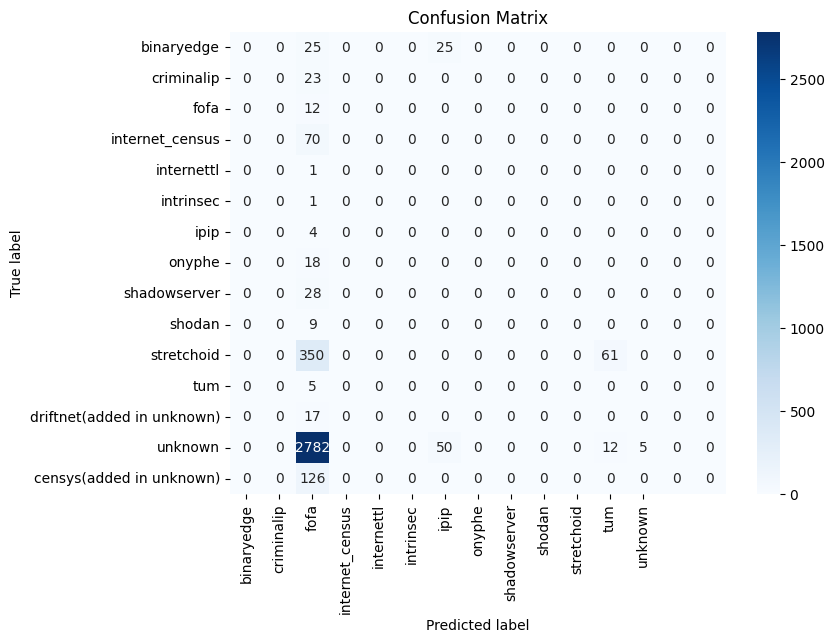

      prediction              ip  groundtruth            timestamp
0              7    45.79.205.89            4  2024-12-11 06:00:50
1              7    45.79.205.89            4  2024-12-11 06:01:08
2              7   138.68.25.139            4  2024-12-11 06:05:03
3              7   138.68.25.139            4  2024-12-11 06:05:22
4              7    45.33.14.155            4  2024-12-11 06:22:47
...          ...             ...          ...                  ...
3619           7  104.234.115.32           26  2024-12-16 15:43:32
3620           7    3.16.162.168           26  2024-12-16 15:46:27
3621           7    3.16.162.168           26  2024-12-16 15:46:55
3622           7  46.101.154.129           26  2024-12-16 15:49:53
3623           7    195.3.223.52           26  2024-12-16 15:57:43

[3624 rows x 4 columns]
Earliest time: 2024-12-10 16:00:00
Latest time: 2024-12-17 16:00:00
2024-12-10 16:00:00 2024-12-17 16:00:00
Segment 1 (2024-12-10 16:00:00 to 2024-12-17 16:00:00):
      p

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step 399 loaded!


100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 41.09it/s]


y_true[closed_mask] [ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  9  9 10 10 10 11 11 11 11 11 11 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 18 18 18 18 18 18 

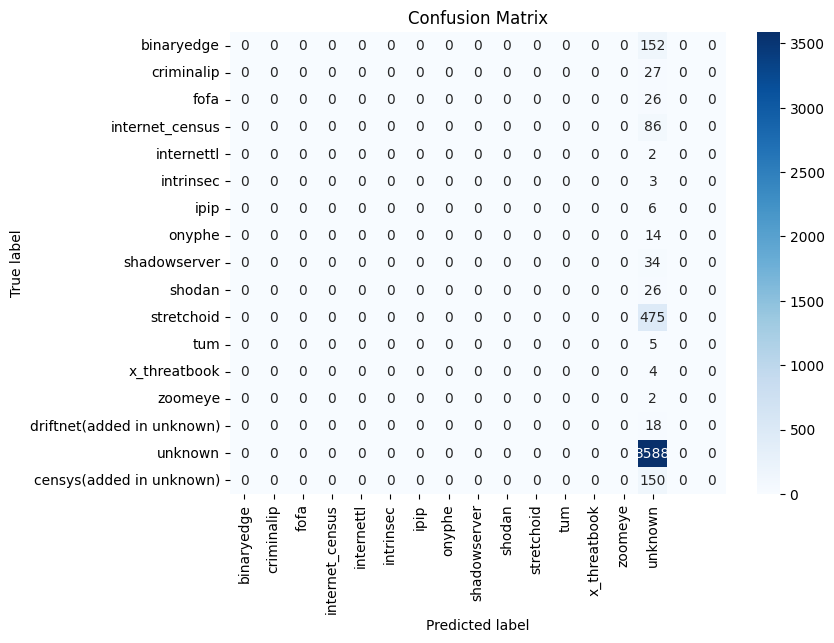

      prediction               ip  groundtruth            timestamp
0             25  139.177.205.201            4  2024-12-16 16:23:49
1             25  206.189.178.198            4  2024-12-16 16:30:18
2             25   178.128.11.118            4  2024-12-16 16:34:27
3             25   97.107.141.112            4  2024-12-16 16:42:40
4             25   173.230.149.27            4  2024-12-17 10:57:47
...          ...              ...          ...                  ...
4613          25  165.154.182.174           23  2024-12-21 20:55:26
4614          25  165.154.182.174           23  2024-12-21 20:55:35
4615          25  165.154.182.174           23  2024-12-21 20:55:44
4616          25   118.123.105.93           24  2024-12-17 05:27:32
4617          25      36.156.22.4           24  2024-12-23 10:19:24

[4618 rows x 4 columns]
Earliest time: 2024-12-17 16:00:00
Latest time: 2024-12-24 16:00:00
2024-12-17 16:00:00 2024-12-24 16:00:00
Segment 1 (2024-12-17 16:00:00 to 2024-12-24 16:00:

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx [4075]
idx_new [4075]
dataset_data (800, 32, 32, 3)
dataset_data (4076, 32, 32, 3)
len_seen_indices 800
dataset_data (800, 32, 32, 3)
dataset_data (4076, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7ff3e6585220> lb_dset 800
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_tls_ep2_bs32/599_model.pth
Model at step 599 loaded!


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 39.54it/s]


y_true[closed_mask] [ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9 10
 10 10 10 10 10 11 11 11 11 11 13 13 13 13 13 13 13 13 13 13 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 

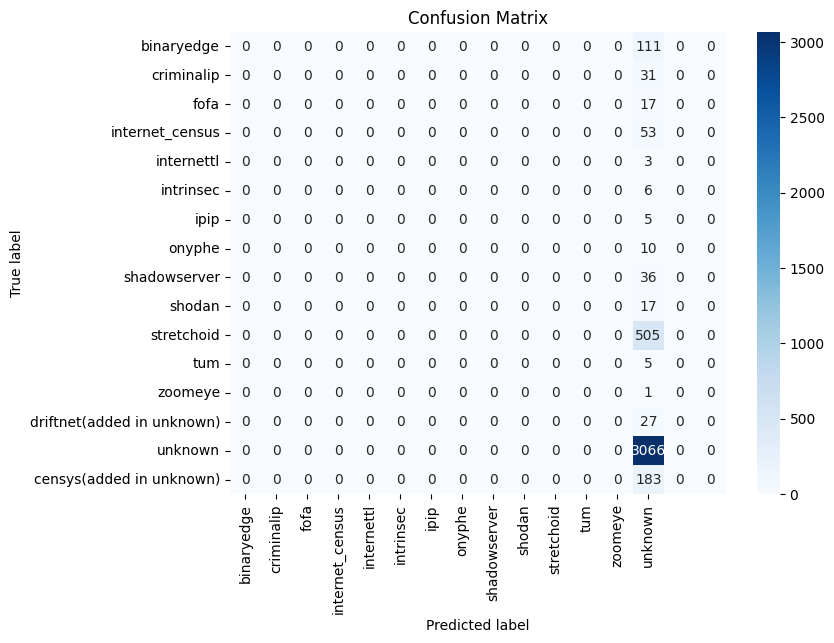

      prediction               ip  groundtruth            timestamp
0             25  157.245.234.135            4  2024-12-23 17:48:06
1             25  173.230.150.122            4  2024-12-23 17:57:03
2             25   165.227.193.73            4  2024-12-23 18:04:47
3             25   206.189.218.69            4  2024-12-23 18:04:54
4             25   165.22.150.190            4  2024-12-23 18:17:56
...          ...              ...          ...                  ...
4071          25     205.210.31.2           26  2024-12-30 15:55:12
4072          25   118.193.57.218           26  2024-12-30 15:55:19
4073          25   118.193.57.218           26  2024-12-30 15:55:29
4074          25   118.193.57.218           26  2024-12-30 15:55:38
4075          25      36.156.22.4           24  2024-12-24 10:54:47

[4076 rows x 4 columns]
Earliest time: 2024-12-24 16:00:00
Latest time: 2024-12-31 16:00:00
2024-12-24 16:00:00 2024-12-31 16:00:00
Segment 1 (2024-12-24 16:00:00 to 2024-12-31 16:00:

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step 799 loaded!


100%|███████████████████████████████████████████| 17/17 [00:00<00:00, 39.62it/s]


y_true[closed_mask] [ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9
  9 10 10 10 10 11 11 11 11 11 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 18 18 18 18 18 18 18 18 18 18 

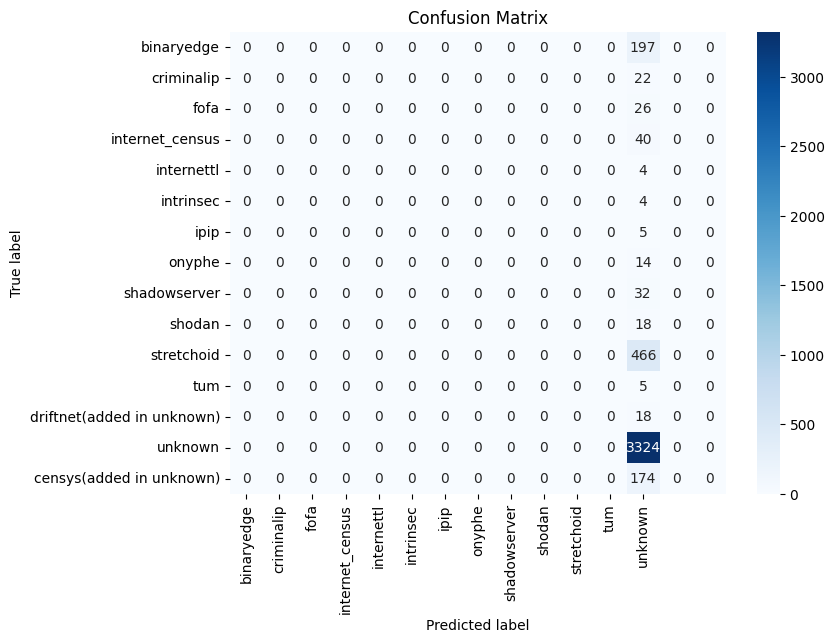

      prediction               ip  groundtruth            timestamp
0             25    161.35.98.203            4  2024-12-30 16:20:52
1             25   134.122.30.138            4  2024-12-30 16:24:56
2             25  206.189.161.157            4  2024-12-30 16:34:05
3             25  173.255.209.220            4  2024-12-30 16:54:08
4             25    45.56.101.233            4  2024-12-31 16:19:31
...          ...              ...          ...                  ...
4344          25    5.181.190.248           26  2025-01-06 15:52:13
4345          25      45.93.9.197           26  2025-01-06 15:54:07
4346          25  157.245.104.121           26  2025-01-06 15:55:08
4347          25    64.23.201.216           26  2025-01-06 15:56:03
4348          25  157.245.104.121           26  2025-01-06 15:56:16

[4349 rows x 4 columns]
Earliest time: 2024-12-31 16:00:00
Latest time: 2025-01-07 16:00:00
2024-12-31 16:00:00 2025-01-07 16:00:00
Segment 1 (2024-12-31 16:00:00 to 2025-01-07 16:00:

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step 999 loaded!


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 42.44it/s]


y_true[closed_mask] [ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  7  7  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8 

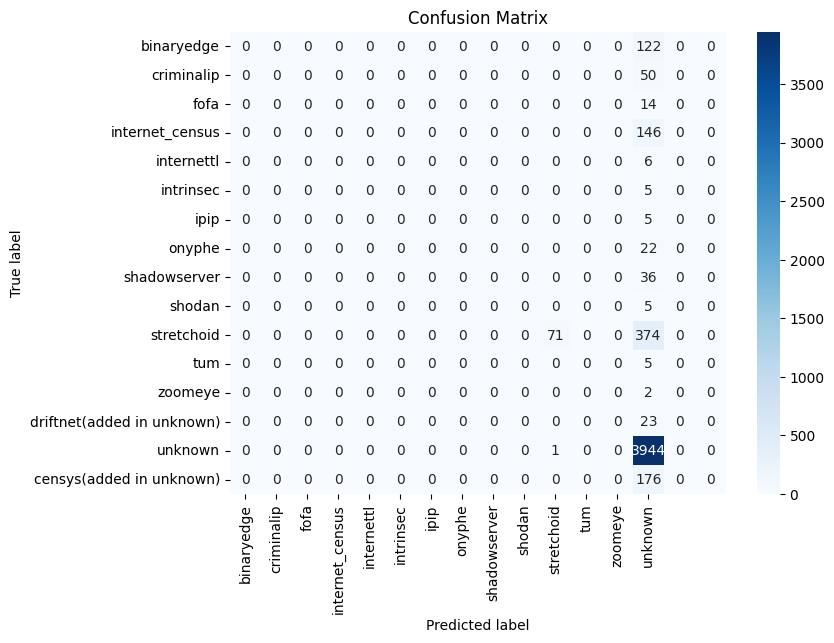

      prediction              ip  groundtruth            timestamp
0             25    50.116.4.178            4  2025-01-06 16:14:47
1             25   157.245.232.1            4  2025-01-06 16:18:11
2             25   72.14.188.150            4  2025-01-06 16:36:42
3             25  159.65.222.147            4  2025-01-06 16:51:14
4             25  165.227.193.73            4  2025-01-07 12:36:38
...          ...             ...          ...                  ...
5002          25    92.255.57.58           26  2025-01-13 15:47:11
5003          25   144.202.82.88           26  2025-01-13 15:49:35
5004          25  78.153.140.203           26  2025-01-13 15:53:00
5005          25     36.156.22.4           24  2025-01-10 18:10:07
5006          25     36.156.22.4           24  2025-01-11 11:16:40

[5007 rows x 4 columns]
Earliest time: 2025-01-07 16:00:00
Latest time: 2025-01-14 16:00:00
2025-01-07 16:00:00 2025-01-14 16:00:00
Segment 1 (2025-01-07 16:00:00 to 2025-01-14 16:00:00):
      p

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step 1199 loaded!


100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 41.92it/s]


y_true[closed_mask] [ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  9  9  9  9  9  9  9 10 10 10 10 10 10 10 11 11 11 11 11
 11 11 11 13 13 13 13 13 13 13 13 13 13 13 13 13 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 19 19 19 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 

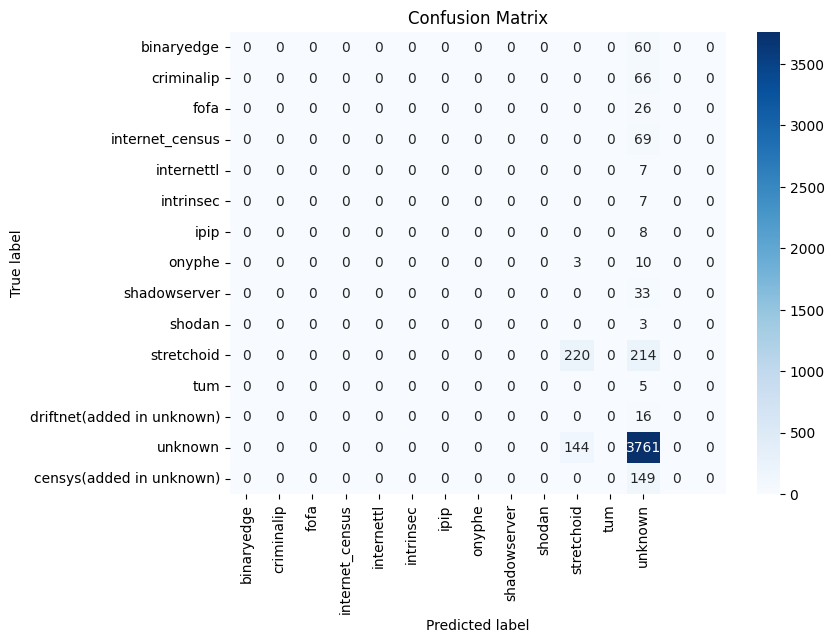

      prediction               ip  groundtruth            timestamp
0             25   165.232.50.225            4  2025-01-13 17:03:54
1             25   167.99.230.196            4  2025-01-13 17:10:57
2             25  104.248.125.209            4  2025-01-13 17:14:15
3             25     45.56.114.18            4  2025-01-13 17:19:36
4             25    64.225.35.196            4  2025-01-13 17:28:37
...          ...              ...          ...                  ...
4796          25      71.6.232.23           26  2025-01-20 15:39:16
4797          25    64.23.201.216           26  2025-01-20 15:48:13
4798          25   185.247.137.20           26  2025-01-20 15:48:33
4799          25   161.97.102.240           26  2025-01-20 15:52:55
4800          25   51.158.173.147           26  2025-01-20 15:58:51

[4801 rows x 4 columns]
Earliest time: 2025-01-14 16:00:00
Latest time: 2025-01-21 16:00:00
2025-01-14 16:00:00 2025-01-21 16:00:00
Segment 1 (2025-01-14 16:00:00 to 2025-01-21 16:00:

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step 1399 loaded!


100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 40.50it/s]


y_true[closed_mask] [ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9
  9  9 10 10 10 11 11 11 11 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 19 19 19 19 19 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 

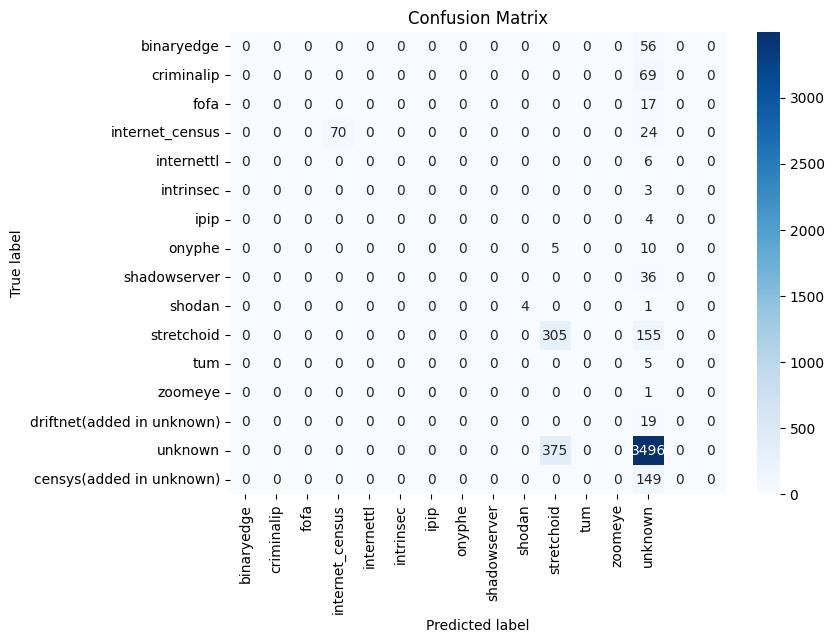

      prediction              ip  groundtruth            timestamp
0             25  165.227.86.201            4  2025-01-20 16:06:32
1             25  167.99.230.196            4  2025-01-20 16:40:19
2             25    50.116.4.205            4  2025-01-20 16:43:13
3             25   45.33.119.126            4  2025-01-20 16:43:57
4             25   172.104.30.66            4  2025-01-21 16:08:58
...          ...             ...          ...                  ...
4805          25    3.66.214.180           26  2025-01-27 15:56:20
4806          25    3.66.214.180           26  2025-01-27 15:56:20
4807          25    3.66.214.180           26  2025-01-27 15:56:20
4808          25    3.66.214.180           26  2025-01-27 15:56:20
4809          25     36.156.22.4           24  2025-01-27 07:05:07

[4810 rows x 4 columns]
Earliest time: 2025-01-21 16:00:00
Latest time: 2025-01-28 16:00:00
2025-01-21 16:00:00 2025-01-28 16:00:00
Segment 1 (2025-01-21 16:00:00 to 2025-01-28 16:00:00):
      p

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step 1599 loaded!


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 42.58it/s]


y_true[closed_mask] [ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8 

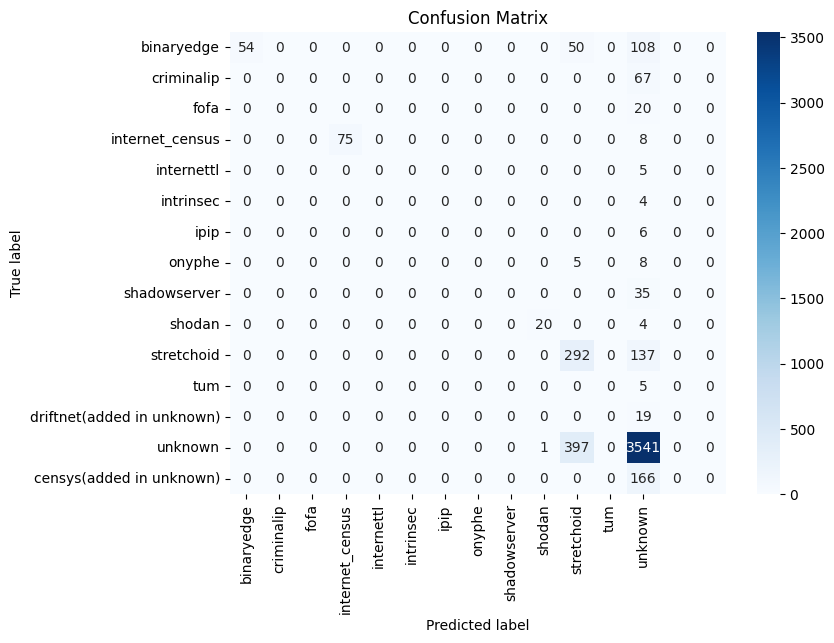

      prediction               ip  groundtruth            timestamp
0              4    45.56.120.118            4  2025-01-27 16:11:50
1              4    50.116.26.235            4  2025-01-27 16:32:17
2              4   165.22.153.221            4  2025-01-27 16:35:08
3              4  157.230.184.105            4  2025-01-27 16:42:39
4             25    64.227.87.132            4  2025-01-28 05:57:26
...          ...              ...          ...                  ...
5022          25    45.79.132.223           26  2025-02-03 15:31:12
5023          25  147.185.133.125           26  2025-02-03 15:35:55
5024          25  147.185.133.125           26  2025-02-03 15:36:05
5025          25    45.130.145.97           26  2025-02-03 15:39:32
5026          25     103.20.61.19           26  2025-02-03 15:53:44

[5027 rows x 4 columns]
Earliest time: 2025-01-28 16:00:00
Latest time: 2025-02-04 16:00:00
2025-01-28 16:00:00 2025-02-04 16:00:00
Segment 1 (2025-01-28 16:00:00 to 2025-02-04 16:00:

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step 1799 loaded!


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 44.26it/s]


y_true[closed_mask] [ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  9  9  9 

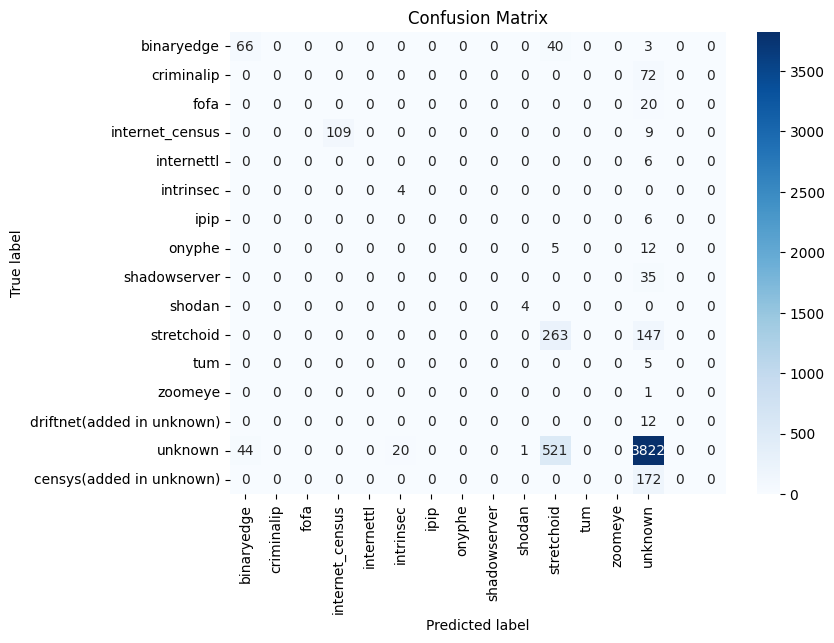

      prediction              ip  groundtruth            timestamp
0              4  206.189.218.69            4  2025-02-03 16:13:25
1              4   45.79.198.243            4  2025-02-03 16:16:42
2              4  206.189.218.69            4  2025-02-03 16:19:45
3              4    45.56.114.35            4  2025-02-03 16:31:18
4              4    23.239.3.146            4  2025-02-03 16:43:09
...          ...             ...          ...                  ...
5394          25  104.234.115.49           26  2025-02-10 15:39:36
5395          25  118.229.43.254           26  2025-02-10 15:51:40
5396          25  118.229.43.254           26  2025-02-10 15:54:14
5397          25    92.255.57.58           26  2025-02-10 15:57:48
5398          25     36.156.22.4           24  2025-02-04 08:44:18

[5399 rows x 4 columns]
Earliest time: 2025-02-04 16:00:00
Latest time: 2025-02-11 16:00:00
2025-02-04 16:00:00 2025-02-11 16:00:00
Segment 1 (2025-02-04 16:00:00 to 2025-02-11 16:00:00):
      p

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step 1999 loaded!


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 41.88it/s]


y_true[closed_mask] [ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  9  9  9  9 10 10 10 10 11 11 11 11 11 11 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 15 15 15 15 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 19 19
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 

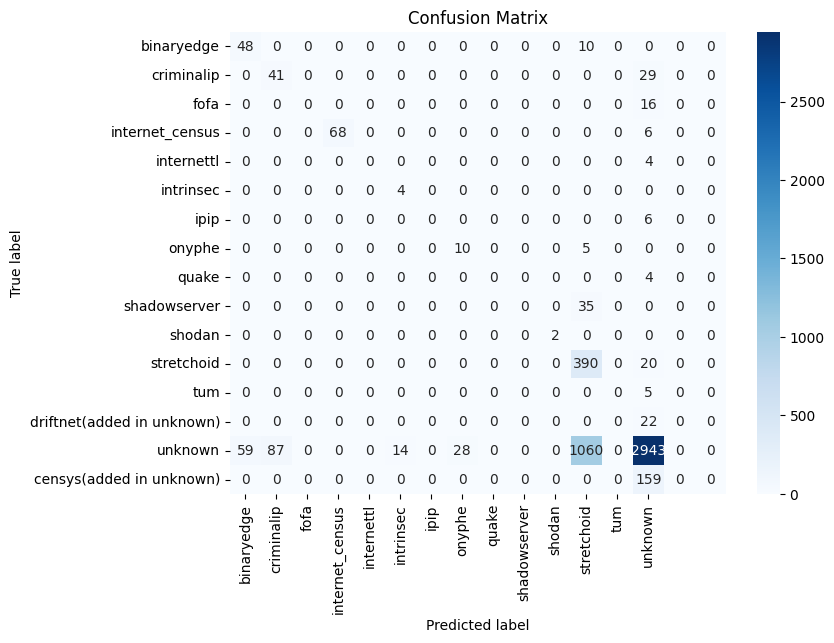

      prediction              ip  groundtruth            timestamp
0              4   64.225.35.196            4  2025-02-10 16:29:59
1              4  157.230.179.26            4  2025-02-10 16:33:44
2              4    68.183.27.94            4  2025-02-10 16:34:25
3              4    68.183.27.94            4  2025-02-10 16:34:44
4              4  159.65.229.110            4  2025-02-10 16:46:14
...          ...             ...          ...                  ...
5070          25    45.148.10.90           26  2025-02-17 15:45:06
5071          25    84.239.12.14           26  2025-02-17 15:48:36
5072          25    84.239.12.14           26  2025-02-17 15:51:30
5073          25  185.47.172.129           26  2025-02-17 15:55:06
5074          25   35.240.100.73           26  2025-02-17 15:58:54

[5075 rows x 4 columns]
Earliest time: 2025-02-11 16:00:00
Latest time: 2025-02-18 16:00:00
2025-02-11 16:00:00 2025-02-18 16:00:00
Segment 1 (2025-02-11 16:00:00 to 2025-02-18 16:00:00):
      p

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step 2199 loaded!


100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 37.13it/s]


y_true[closed_mask] [ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  9  9  9  9  9  9 10 10 10 10 11 11 11 11 11 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 15 15 15 15 15 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 19 19
 19 19 19 19 19 19 19 19 19 20 

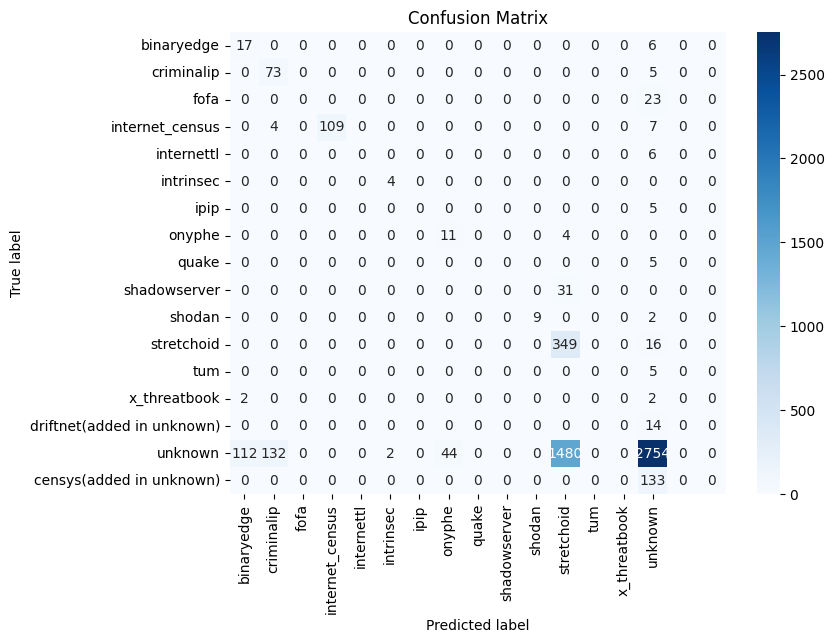

      prediction               ip  groundtruth            timestamp
0              4    68.183.109.19            4  2025-02-17 19:35:07
1              4  178.128.155.247            4  2025-02-17 19:56:09
2              4     138.68.10.97            4  2025-02-17 20:02:46
3              4   192.155.89.165            4  2025-02-17 20:15:22
4              4   142.93.199.199            4  2025-02-18 12:25:55
...          ...              ...          ...                  ...
5361          25   45.144.212.139           26  2025-02-24 15:59:18
5362          25   152.32.187.105           23  2025-02-24 15:43:21
5363          25   152.32.187.105           23  2025-02-24 15:43:30
5364           4   152.32.187.105           23  2025-02-24 15:43:39
5365           4   152.32.187.105           23  2025-02-24 15:43:48

[5366 rows x 4 columns]
Earliest time: 2025-02-18 16:00:00
Latest time: 2025-02-25 16:00:00
2025-02-18 16:00:00 2025-02-25 16:00:00
Segment 1 (2025-02-18 16:00:00 to 2025-02-25 16:00:

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 765
dataset_data (765, 32, 32, 3)
dataset_data (5834, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7ff3e8136790> lb_dset 765
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_tls_ep2_bs32/2399_model.pth
Model at step 2399 loaded!


100%|███████████████████████████████████████████| 23/23 [00:00<00:00, 43.86it/s]


y_true[closed_mask] [ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  9  9  9  9  9  9 10 10 10 10 10 11 11 11 11 11
 11 13 13 13 13 13 13 13 13 13 13 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 19 19 19 19 19
 19 19 19 19 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 

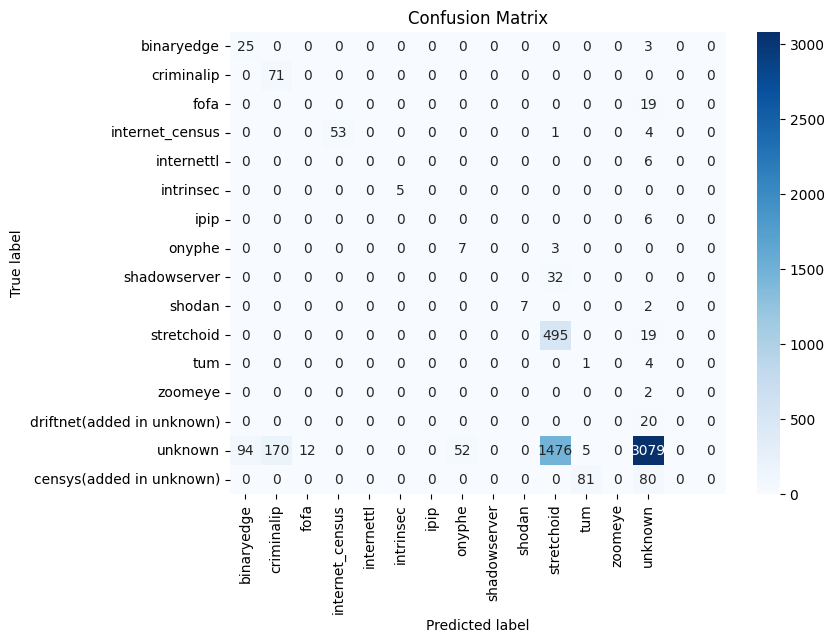

      prediction               ip  groundtruth            timestamp
0              4    138.68.235.44            4  2025-02-24 16:32:11
1             25    66.228.44.120            4  2025-02-24 21:03:17
2             25  104.237.145.207            4  2025-02-27 19:25:52
3             25   104.237.145.35            4  2025-02-27 19:29:02
4              4    96.126.112.60            4  2025-02-28 17:32:10
...          ...              ...          ...                  ...
5829          25   45.144.212.139           26  2025-03-03 15:57:11
5830          25  194.120.230.215           26  2025-03-03 15:57:17
5831          25    196.251.72.73           26  2025-03-03 15:57:44
5832          25      36.156.22.4           24  2025-02-25 22:56:14
5833          25      36.156.22.4           24  2025-03-01 22:50:02

[5834 rows x 4 columns]
Earliest time: 2025-02-25 16:00:00
Latest time: 2025-03-04 16:00:00
2025-02-25 16:00:00 2025-03-04 16:00:00
Segment 1 (2025-02-25 16:00:00 to 2025-03-04 16:00:

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 831
dataset_data (831, 32, 32, 3)
dataset_data (5808, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7ff418988280> lb_dset 831
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_tls_ep2_bs32/2599_model.pth
Model at step 2599 loaded!


100%|███████████████████████████████████████████| 23/23 [00:00<00:00, 44.38it/s]


y_true[closed_mask] [ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9 10
 10 10 10 11 11 11 11 11 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 19 19 19 19 19 19 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 

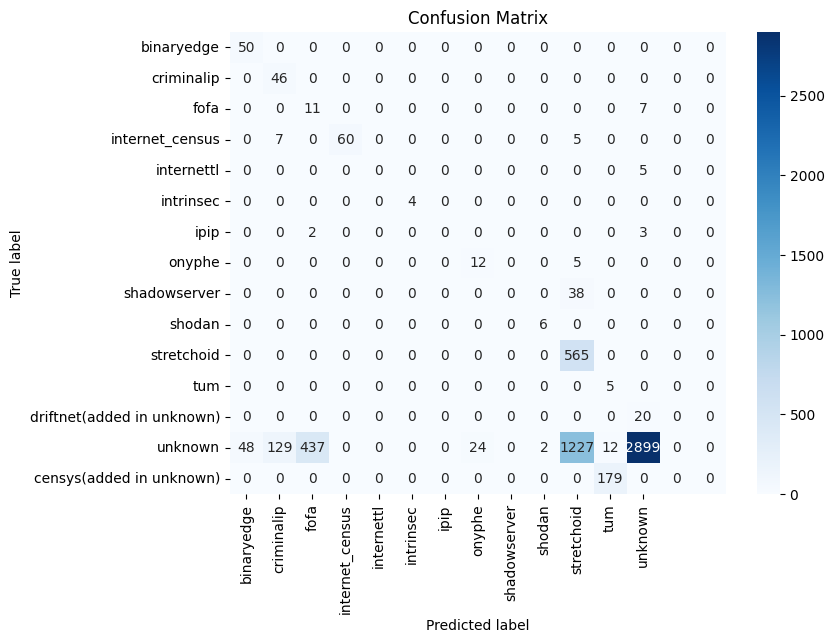

      prediction              ip  groundtruth            timestamp
0              4  138.68.253.248            4  2025-03-03 19:35:56
1              4    45.33.84.149            4  2025-03-03 19:50:45
2              4    50.116.13.48            4  2025-03-03 19:52:09
3              4   50.116.35.234            4  2025-03-03 19:54:17
4              4    142.93.17.11            4  2025-03-03 20:05:56
...          ...             ...          ...                  ...
5803           4    118.26.36.18           26  2025-03-10 15:56:15
5804          25    118.26.36.18           26  2025-03-10 15:56:43
5805          25    118.26.36.18           26  2025-03-10 15:56:52
5806          25    92.255.57.58           26  2025-03-10 15:58:07
5807           4    118.26.36.18           26  2025-03-10 15:58:47

[5808 rows x 4 columns]
Earliest time: 2025-03-04 16:00:00
Latest time: 2025-03-11 16:00:00
2025-03-04 16:00:00 2025-03-11 16:00:00
Segment 1 (2025-03-04 16:00:00 to 2025-03-11 16:00:00):
      p

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


{'segment_1.csv':                    ip  label pred_label_tls
0     138.197.208.114      4              4
1       97.107.131.76      4              4
2        45.33.84.149      4              4
3      206.189.228.16      4              4
4        45.79.111.57      4              4
...               ...    ...            ...
4822     64.227.0.144     26             25
4830    45.79.184.178     26             25
4843   137.74.246.152     26             20
4848   107.170.12.173     26             20
4849     118.26.36.18     26              4

[1441 rows x 3 columns]}
[('2024-12-10', '2024-12-17'), ('2024-12-17', '2024-12-24'), ('2024-12-24', '2024-12-31'), ('2024-12-31', '2025-01-07'), ('2025-01-07', '2025-01-14'), ('2025-01-14', '2025-01-21'), ('2025-01-21', '2025-01-28'), ('2025-01-28', '2025-02-04'), ('2025-02-04', '2025-02-11'), ('2025-02-11', '2025-02-18'), ('2025-02-18', '2025-02-25'), ('2025-02-25', '2025-03-04'), ('2025-03-04', '2025-03-11')]
start_date_str 2024-12-10 end_date_st

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 39.38it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


y_true[closed_mask] [ 5  5  5  5  5  5  5  5  5  5  6  6  9  9  9  9 13 13 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 19 19 19 19 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20]
pred_hat_p[closed_mask] [ 1  1  1  1  1  1  1  1  1  1  7  7  1  1  1  1  1  1 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18  1  1  1  1 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
 21 21  1  1  1  1  1  1  1  1  1  1 21 21 21 21 21 21 21 21 21 21 21 21
 21 21 21 21 21 21 21 21]
o_acc_f_q_filtered 0.1111111111111111
o_acc_f_q_filtered_masked 0.125
fscore 0.0050244332291917 f_hq 0.00010321840136372153
##################################################

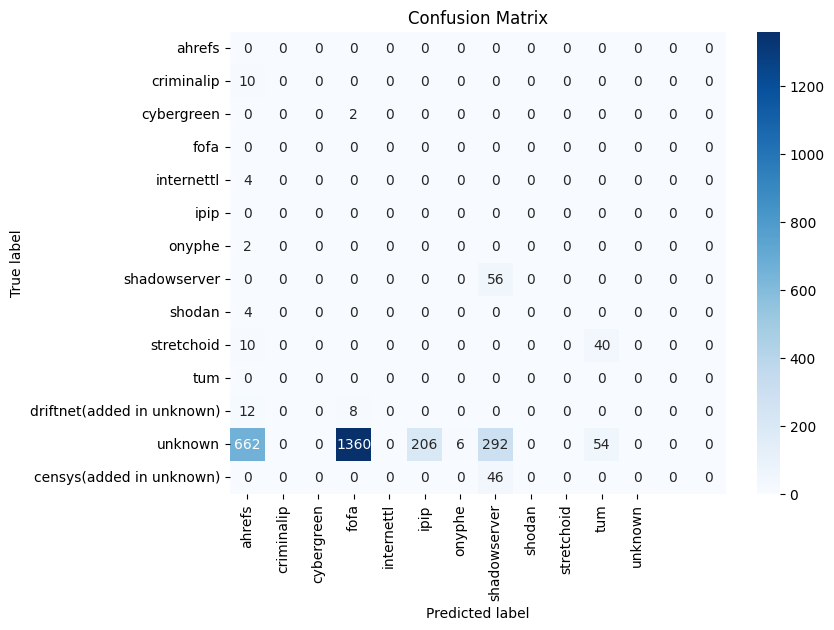

      prediction              ip  groundtruth            timestamp
0             18  162.142.125.95           27  2024-12-10 22:09:39
1             18     192.168.2.0           27  2024-12-10 22:09:39
2             18  167.94.138.145           27  2024-12-11 00:33:51
3             18     192.168.3.0           27  2024-12-11 00:33:51
4             18  167.94.138.159           27  2024-12-11 01:47:11
...          ...             ...          ...                  ...
2769           1     192.168.2.0           26  2024-12-16 15:27:58
2770           7  194.55.186.231           26  2024-12-16 15:44:40
2771           7     192.168.1.0           26  2024-12-16 15:44:40
2772           7  194.55.186.231           26  2024-12-16 15:50:40
2773           7     192.168.1.0           26  2024-12-16 15:50:40

[2774 rows x 4 columns]
Earliest time: 2024-12-10 16:00:00
Latest time: 2024-12-17 16:00:00
2024-12-10 16:00:00 2024-12-17 16:00:00
Segment 1 (2024-12-10 16:00:00 to 2024-12-17 16:00:00):
      p

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 258
dataset_data (258, 16, 16, 3)
dataset_data (3845, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7ff27804f100> lb_dset 258
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_dns_ep2_bs32/399_model.pth
Model at step 399 loaded!


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 48.76it/s]


y_true[closed_mask] [ 5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  9  9  9  9  9  9 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 19 19 19 19 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]
pred_hat_p[closed_mask] [18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18

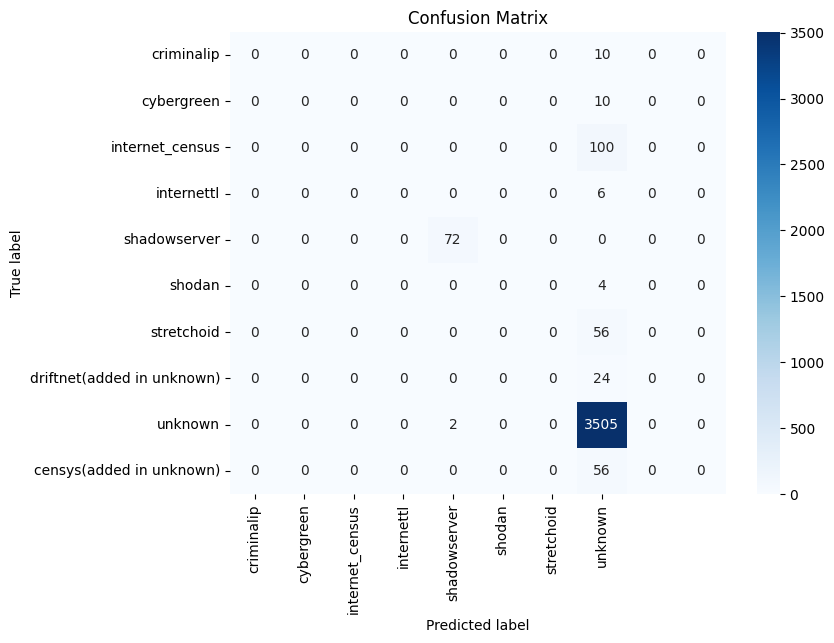

      prediction              ip  groundtruth            timestamp
0             25  206.168.34.167           27  2024-12-16 20:03:44
1             25     192.168.1.0           27  2024-12-16 20:03:44
2             25  167.94.138.151           27  2024-12-16 21:44:29
3             25     192.168.3.0           27  2024-12-16 21:44:29
4             25  167.94.138.133           27  2024-12-16 23:08:12
...          ...             ...          ...                  ...
3840          25     192.168.1.0           26  2024-12-23 15:36:46
3841          25      183.6.9.71           26  2024-12-23 15:40:04
3842          25     192.168.4.0           26  2024-12-23 15:40:04
3843          25  194.55.186.231           26  2024-12-23 15:54:29
3844          25     192.168.1.0           26  2024-12-23 15:54:29

[3845 rows x 4 columns]
Earliest time: 2024-12-17 16:00:00
Latest time: 2024-12-24 16:00:00
2024-12-17 16:00:00 2024-12-24 16:00:00
Segment 1 (2024-12-17 16:00:00 to 2024-12-24 16:00:00):
      p

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


samples_per_class 100 idx [172 173 174 175 176 177 178 179 180 181 182 183]
idx_new [172 173 174 175 176 177 178 179 180 181 182 183]
samples_per_class 100 idx [184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240 241 242 243 244 245]
idx_new [184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240 241 242 243 244 245]
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
dataset_data (170, 16, 16, 3)
dataset_data (3798, 16, 16, 3)
len_seen_indices 170
dataset_data (170, 16, 16, 3)
dataset_data (3798, 16, 16, 3)
lb_dset <semilearn.data

100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 46.93it/s]


y_true[closed_mask] [ 5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  9  9  9  9
  9  9 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 19 19 19 19 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20]
pred_hat_p[closed_mask] [18 18 18 18 18 18 18 18 18 18  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 20 20 20 20 20 20 20 20 20 20 18 18
 18 18 18 18 18 18 18 18 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20

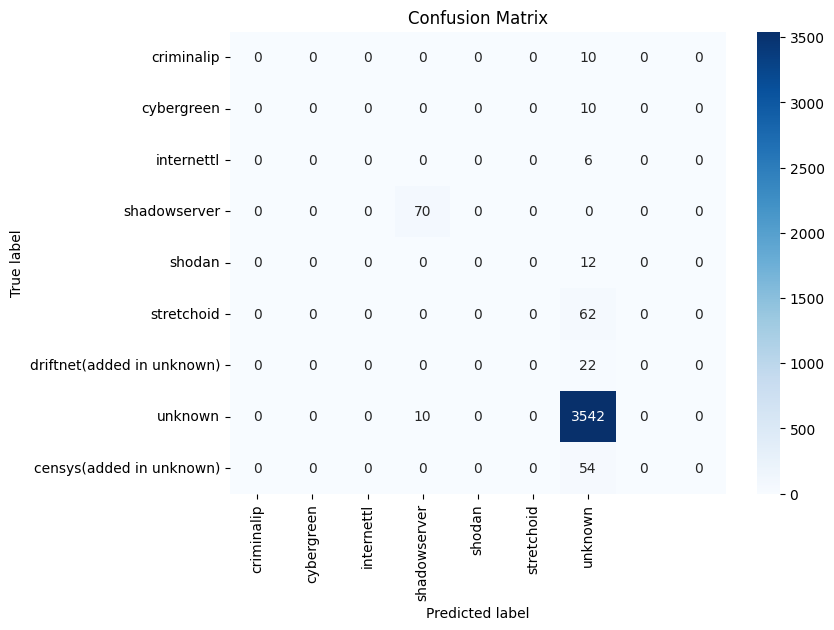

      prediction              ip  groundtruth            timestamp
0             25  162.142.125.85           27  2024-12-23 21:52:00
1             25     192.168.1.0           27  2024-12-23 21:52:00
2             25  162.142.125.84           27  2024-12-23 23:47:56
3             25     192.168.3.0           27  2024-12-23 23:47:56
4             25  199.45.154.186           27  2024-12-24 05:53:18
...          ...             ...          ...                  ...
3793          25     192.168.1.0           26  2024-12-30 15:29:42
3794          25    45.88.91.184           26  2024-12-30 15:32:18
3795          25     192.168.4.0           26  2024-12-30 15:32:18
3796          25    45.88.91.184           26  2024-12-30 15:36:09
3797          25     192.168.3.0           26  2024-12-30 15:36:09

[3798 rows x 4 columns]
Earliest time: 2024-12-24 16:00:00
Latest time: 2024-12-31 16:00:00
2024-12-24 16:00:00 2024-12-31 16:00:00
Segment 1 (2024-12-24 16:00:00 to 2024-12-31 16:00:00):
      p

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step 799 loaded!


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 46.79it/s]


y_true[closed_mask] [ 5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  9  9  9  9  9  9  9  9  9  9 13 13 13 13 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 19 19 19 19 19 19 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]
pred_hat_p[closed_mask] [ 8  8  8  8  8  8  8  8  8  8  6  6  6  6  6  6  6  6  6  6  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  9  9  9  9  9  9  9  9  8  8  8  8  8  8 18 18 18 18 18 18 18 18 18 18
 18 18

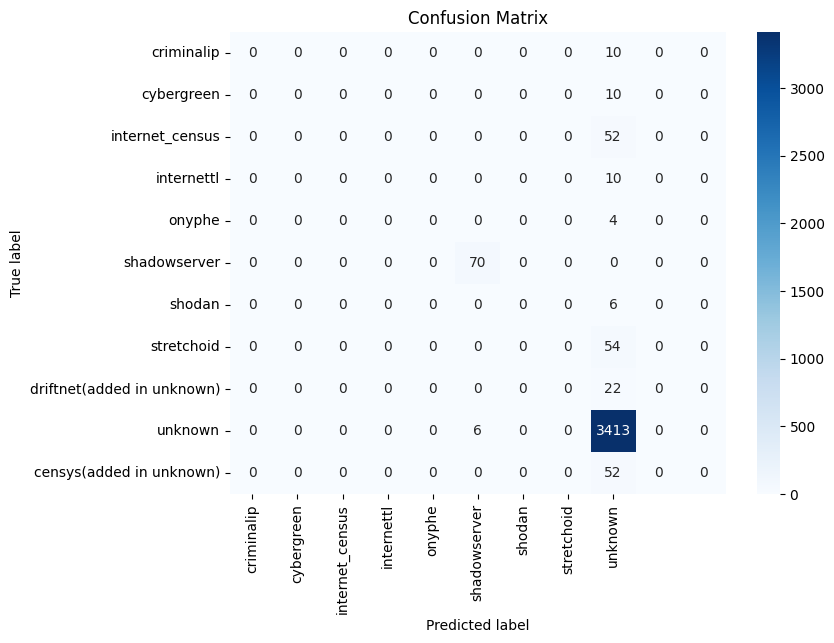

      prediction              ip  groundtruth            timestamp
0             25  162.142.125.84           27  2024-12-30 19:08:25
1             25     192.168.1.0           27  2024-12-30 19:08:25
2             25  162.142.125.90           27  2024-12-30 19:14:20
3             25     192.168.3.0           27  2024-12-30 19:14:20
4             25  206.168.34.160           27  2024-12-30 22:55:26
...          ...             ...          ...                  ...
3704          25     192.168.3.0           26  2025-01-06 15:37:51
3705          25  213.21.237.231           26  2025-01-06 15:41:03
3706          25     192.168.5.0           26  2025-01-06 15:41:03
3707          25  154.213.186.25           26  2025-01-06 15:44:03
3708          25     192.168.4.0           26  2025-01-06 15:44:03

[3709 rows x 4 columns]
Earliest time: 2024-12-31 16:00:00
Latest time: 2025-01-07 16:00:00
2024-12-31 16:00:00 2025-01-07 16:00:00
Segment 1 (2024-12-31 16:00:00 to 2025-01-07 16:00:00):
      p

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 220
dataset_data (220, 16, 16, 3)
dataset_data (3644, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7ff4188b30a0> lb_dset 220
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_dns_ep2_bs32/999_model.pth
Model at step 999 loaded!


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 46.61it/s]


y_true[closed_mask] [ 5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9
  9  9  9  9  9  9 13 13 16 16 16 16 16 16 16 16 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 19 19 19 19 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20]
pred_hat_p[closed_mask] [ 8  8  8  8  8  8  8  8  8  8  6  6  6  6  6  6  6  6  6  6  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  8  8  8  8  8  8  8  8  8  8 18 18 18 18 18 18

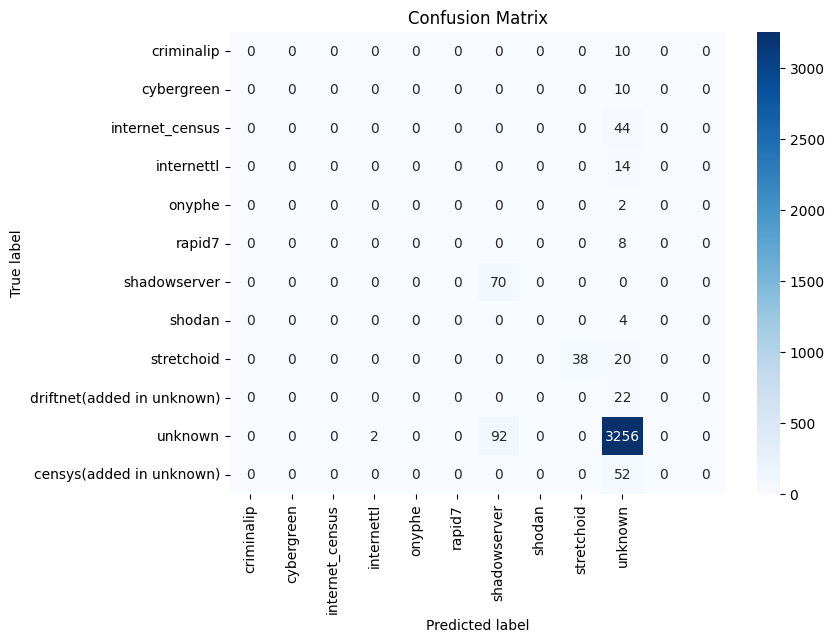

      prediction              ip  groundtruth            timestamp
0             25  162.142.125.92           27  2025-01-06 19:06:13
1             25     192.168.4.0           27  2025-01-06 19:06:13
2             25  206.168.34.169           27  2025-01-06 21:58:35
3             25     192.168.4.0           27  2025-01-06 21:58:35
4             25  167.94.138.144           27  2025-01-07 08:38:37
...          ...             ...          ...                  ...
3639          25     192.168.1.0           26  2025-01-13 15:38:55
3640          25   47.91.125.252           26  2025-01-13 15:49:38
3641          25     192.168.2.0           26  2025-01-13 15:49:38
3642          25  198.235.24.153           26  2025-01-13 15:59:23
3643          25     192.168.1.0           26  2025-01-13 15:59:23

[3644 rows x 4 columns]
Earliest time: 2025-01-07 16:00:00
Latest time: 2025-01-14 16:00:00
2025-01-07 16:00:00 2025-01-14 16:00:00
Segment 1 (2025-01-07 16:00:00 to 2025-01-14 16:00:00):
      p

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 178
dataset_data (178, 16, 16, 3)
dataset_data (3912, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7ff43810be20> lb_dset 178
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_dns_ep2_bs32/1199_model.pth
Model at step 1199 loaded!


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 41.64it/s]


y_true[closed_mask] [ 4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  6  6  6  6
  6  6  6  6  6  6  9  9  9  9  9  9  9  9  9  9  9  9  9  9 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 19 19 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20]
pred_hat_p[closed_mask] [ 8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  6  6  6  6
  6  6  6  6  6  6  9  9  9  9  9  9  9  9  9  9  9  9  9  9 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 19 19 20 20 20 20
 20 20 20 20  8  8  8  8  8  8  8  8  8  8 20 20

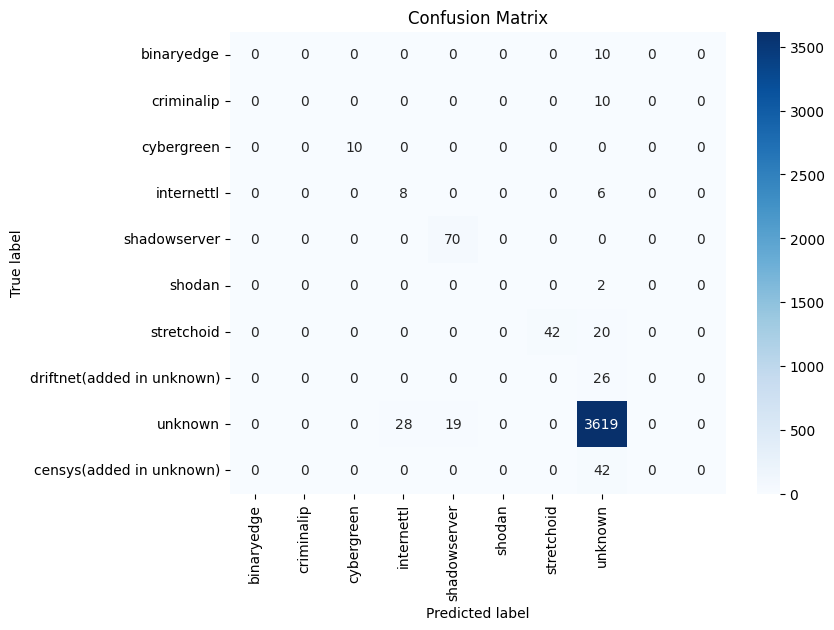

      prediction               ip  groundtruth            timestamp
0             25  170.187.149.240            4  2025-01-14 07:55:57
1             25      192.168.3.0            4  2025-01-14 07:55:57
2             25  206.189.209.185            4  2025-01-14 07:59:30
3             25      192.168.4.0            4  2025-01-14 07:59:30
4             25  170.187.149.113            4  2025-01-14 08:03:05
...          ...              ...          ...                  ...
3907          25      192.168.4.0           26  2025-01-20 15:28:04
3908          25    161.129.64.81           26  2025-01-20 15:30:00
3909          25      192.168.1.0           26  2025-01-20 15:30:00
3910          25    161.129.64.81           26  2025-01-20 15:39:46
3911          25      192.168.4.0           26  2025-01-20 15:39:46

[3912 rows x 4 columns]
Earliest time: 2025-01-14 16:00:00
Latest time: 2025-01-21 16:00:00
2025-01-14 16:00:00 2025-01-21 16:00:00
Segment 1 (2025-01-14 16:00:00 to 2025-01-21 16:00:

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


start_date_str 2025-01-21 end_date_str 2025-01-28
rm data/selfdeploy_24_25_1week_dns_openset/labeled_idx/*
0
dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx [38 39 40 41 42 43 44 45 46 47]
idx_new [38 39 40 41 42 43 44 45 46 47]
samples_per_class 100 idx [48 49 50 51 52 53 54 55 56 57]
idx_new [48 49 50 51 52 53 54 55 56 57]
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx [ 78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 1

100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 47.41it/s]


y_true[closed_mask] [ 5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  9  9  9  9  9  9  9  9  9  9  9  9 13 13 13 13 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]
pred_hat_p[closed_mask] [ 8  8  8  8  8  8  8  8  8  8  6  6  6  6  6  6  6  6  6  6  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8

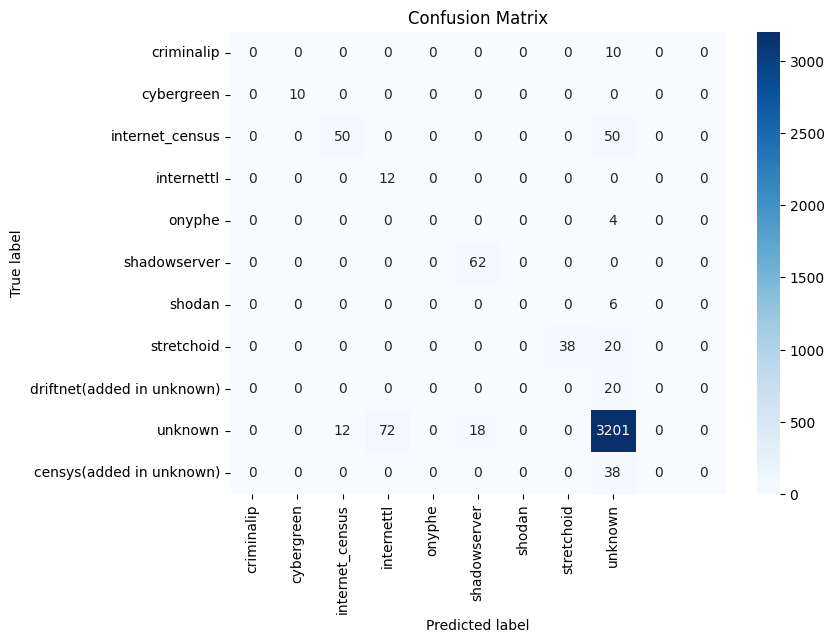

      prediction               ip  groundtruth            timestamp
0             25   162.142.125.86           27  2025-01-20 19:38:27
1             25      192.168.1.0           27  2025-01-20 19:38:27
2             25   206.168.34.164           27  2025-01-20 20:06:13
3             25      192.168.4.0           27  2025-01-20 20:06:13
4             25   206.168.34.172           27  2025-01-20 21:21:54
...          ...              ...          ...                  ...
3618          25      192.168.5.0           26  2025-01-27 15:31:27
3619          25  178.215.238.244           26  2025-01-27 15:40:11
3620          25      192.168.2.0           26  2025-01-27 15:40:11
3621          25  178.215.238.244           26  2025-01-27 15:45:43
3622          25      192.168.3.0           26  2025-01-27 15:45:43

[3623 rows x 4 columns]
Earliest time: 2025-01-21 16:00:00
Latest time: 2025-01-28 16:00:00
2025-01-21 16:00:00 2025-01-28 16:00:00
Segment 1 (2025-01-21 16:00:00 to 2025-01-28 16:00:

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


num_labels 2500 num_classes 25 this mode use all samples
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx [60 61 62 63 64 65 66 67 68 69]
idx_new [60 61 62 63 64 65 66 67 68 69]
samples_per_class 100 idx [70 71 72 73 74 75 76 77 78 79]
idx_new [70 71 72 73 74 75 76 77 78 79]
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx [102 103 104 105 106 107 108 109 110 111 112 113 114 115]
idx_new [102 103 104 105 106 107 108 109 110 111 112 113 114 115]
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx [116 117]
idx_new [116 117]
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 i

100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 48.12it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


y_true[closed_mask] [ 5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  9  9  9  9
  9  9  9  9  9  9  9  9  9  9 13 13 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 19 19 19 19 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]
pred_hat_p[closed_mask] [ 8  8  8  8  8  8  8  8  8  8  6  6  6  6  6  6  6  6  6  6  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  8  8 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 19 19 19 19  8  8  8  8  8  8  8  8  8  8
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20

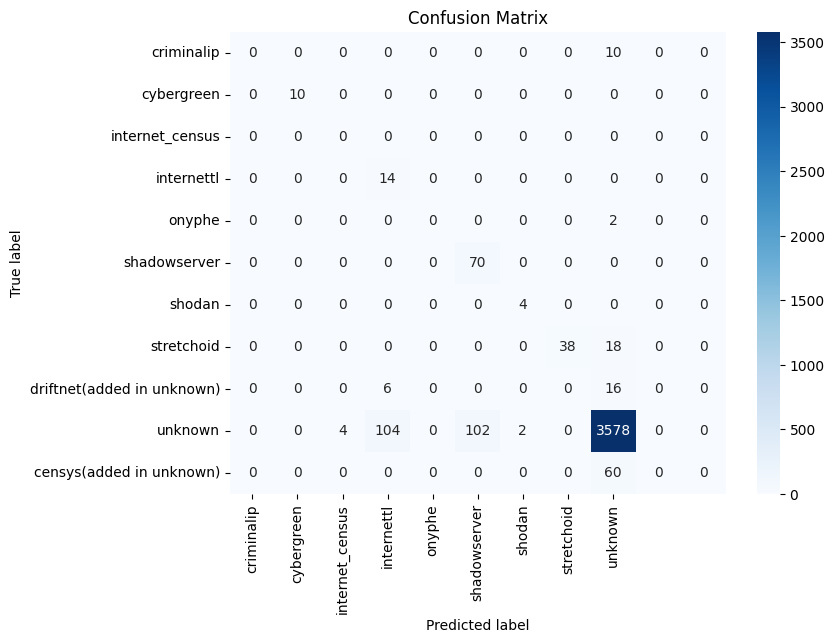

      prediction              ip  groundtruth            timestamp
0             25  167.94.138.141           27  2025-01-27 17:48:18
1             25     192.168.3.0           27  2025-01-27 17:48:18
2             25  167.94.138.151           27  2025-01-27 19:03:16
3             25     192.168.2.0           27  2025-01-27 19:03:16
4             25  199.45.154.182           27  2025-01-28 01:07:53
...          ...             ...          ...                  ...
4033          25     192.168.3.0           26  2025-02-03 15:44:40
4034          25   103.88.234.63           26  2025-02-03 15:46:31
4035          25     192.168.5.0           26  2025-02-03 15:46:31
4036          25   103.88.234.63           26  2025-02-03 15:47:55
4037          25     192.168.4.0           26  2025-02-03 15:47:55

[4038 rows x 4 columns]
Earliest time: 2025-01-28 16:00:00
Latest time: 2025-02-04 16:00:00
2025-01-28 16:00:00 2025-02-04 16:00:00
Segment 1 (2025-01-28 16:00:00 to 2025-02-04 16:00:00):
      p

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


samples_per_class 100 idx [140 141]
idx_new [140 141]
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx [142 143 144 145 146 147 148 149 150 151 152 153]
idx_new [142 143 144 145 146 147 148 149 150 151 152 153]
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx [154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207
 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225
 226 227 228 229 230 231]
idx_new [154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207
 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225
 226 227 228 229 230 231]
samples_per_class 100 

100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 47.58it/s]


y_true[closed_mask] [ 6  6  6  6  6  6  6  6  6  6  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9
 13 13 16 16 16 16 16 16 16 16 16 16 16 16 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 19 19 19 19
 19 19 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20]
pred_hat_p[closed_mask] [ 6  6  6  6  6  6  6  6  6  6  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9
  8  8 20 20 20 20 20 20 20 20 20 20 20 20 18 18

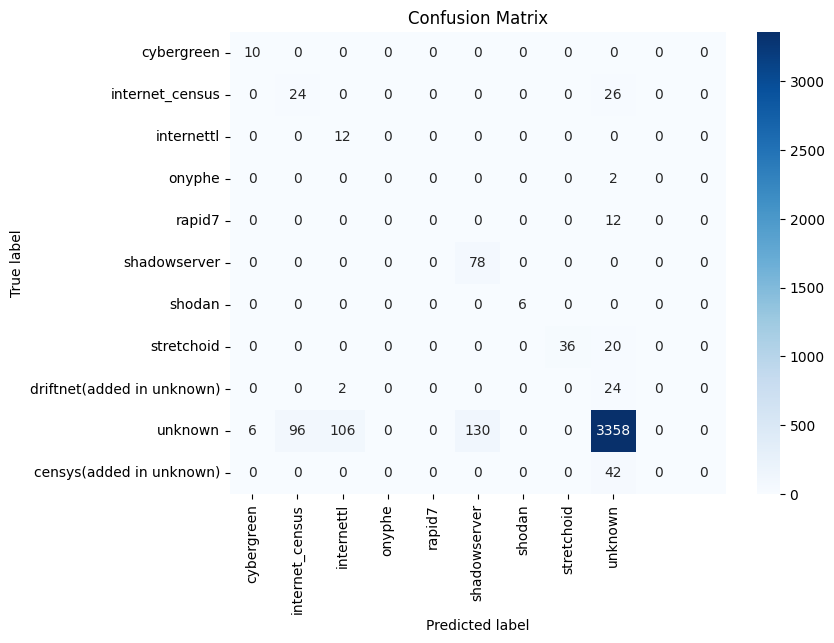

      prediction              ip  groundtruth            timestamp
0             25  206.168.34.167           27  2025-02-03 23:09:15
1             25     192.168.3.0           27  2025-02-03 23:09:15
2             25  167.94.138.152           27  2025-02-05 12:40:36
3             25     192.168.3.0           27  2025-02-05 12:40:36
4             25  162.142.125.92           27  2025-02-05 17:37:09
...          ...             ...          ...                  ...
3985          25     192.168.1.0           26  2025-02-10 15:45:05
3986           9   51.159.103.10           26  2025-02-10 15:50:35
3987           9     192.168.5.0           26  2025-02-10 15:50:35
3988          25    8.211.162.45           26  2025-02-10 15:52:50
3989          25     192.168.3.0           26  2025-02-10 15:52:50

[3990 rows x 4 columns]
Earliest time: 2025-02-04 16:00:00
Latest time: 2025-02-11 16:00:00
2025-02-04 16:00:00 2025-02-11 16:00:00
Segment 1 (2025-02-04 16:00:00 to 2025-02-11 16:00:00):
      p

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 236
dataset_data (236, 16, 16, 3)
dataset_data (3514, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7ff3e6275910> lb_dset 236
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_dns_ep2_bs32/1999_model.pth
Model at step 1999 loaded!


100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 44.58it/s]


y_true[closed_mask] [ 4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9
 13 13 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 19 19 19 19 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]
pred_hat_p[closed_mask] [ 8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  6  6  6  6  6  6  6  6  6  6  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8

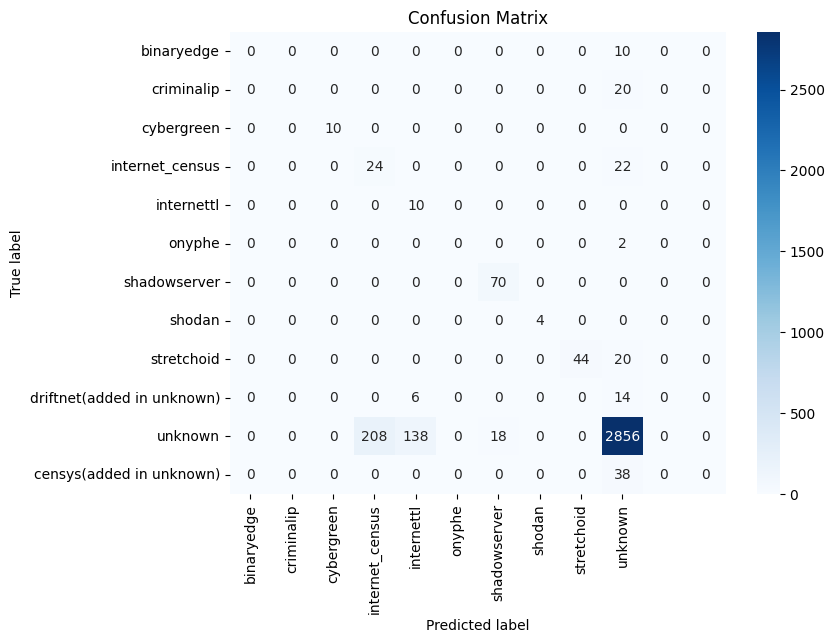

      prediction               ip  groundtruth            timestamp
0             25     142.93.84.58            4  2025-02-11 07:08:28
1             25      192.168.3.0            4  2025-02-11 07:08:28
2             25  194.195.209.117            4  2025-02-11 07:35:04
3             25      192.168.4.0            4  2025-02-11 07:35:04
4             25    198.58.96.113            4  2025-02-11 07:37:14
...          ...              ...          ...                  ...
3509           9      192.168.5.0           26  2025-02-17 15:42:49
3510          25   204.76.203.182           26  2025-02-17 15:52:44
3511          25      192.168.1.0           26  2025-02-17 15:52:44
3512          25    198.98.55.125           26  2025-02-17 15:52:45
3513          25      192.168.2.0           26  2025-02-17 15:52:45

[3514 rows x 4 columns]
Earliest time: 2025-02-11 16:00:00
Latest time: 2025-02-18 16:00:00
2025-02-11 16:00:00 2025-02-18 16:00:00
Segment 1 (2025-02-11 16:00:00 to 2025-02-18 16:00:

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 160
dataset_data (160, 16, 16, 3)
dataset_data (3242, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7ff418cc0250> lb_dset 160
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_dns_ep2_bs32/2199_model.pth
Model at step 2199 loaded!


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 43.33it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


y_true[closed_mask] [ 6  6  6  6  6  6  6  6  6  6  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 13 13 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 19 19 19 19
 19 19 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]
pred_hat_p[closed_mask] [ 6  6  6  6  6  6  6  6  6  6  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 20 20 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 19 19 19 19
 19 19 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20

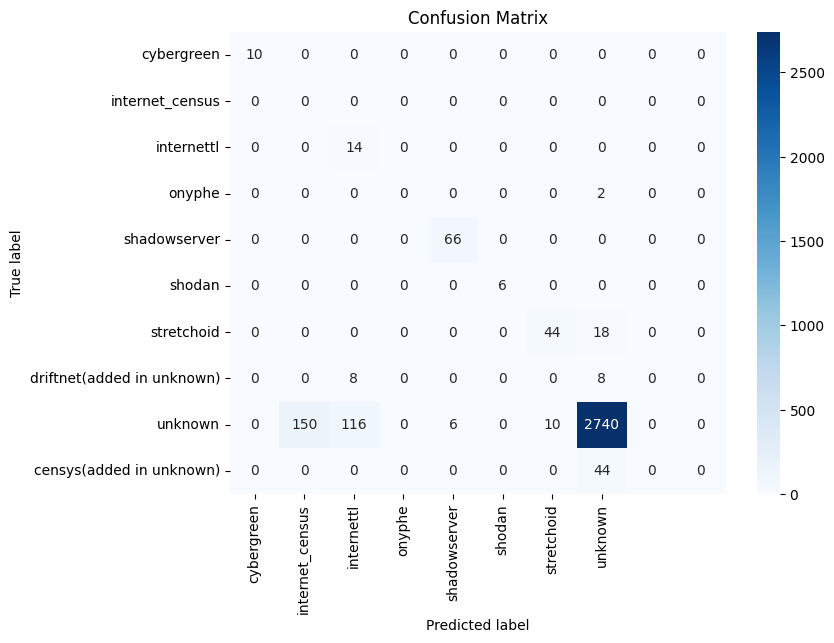

      prediction              ip  groundtruth            timestamp
0             25  199.45.154.186           27  2025-02-18 03:21:20
1             25     192.168.5.0           27  2025-02-18 03:21:20
2             25  167.94.138.131           27  2025-02-18 12:24:45
3             25     192.168.1.0           27  2025-02-18 12:24:45
4             25  167.94.138.150           27  2025-02-18 15:29:53
...          ...             ...          ...                  ...
3237          25     192.168.5.0           26  2025-02-24 15:47:46
3238          25   147.185.132.9           26  2025-02-24 15:51:44
3239          25     192.168.2.0           26  2025-02-24 15:51:44
3240          25   204.76.203.80           26  2025-02-24 15:54:38
3241          25     192.168.4.0           26  2025-02-24 15:54:38

[3242 rows x 4 columns]
Earliest time: 2025-02-18 16:00:00
Latest time: 2025-02-25 16:00:00
2025-02-18 16:00:00 2025-02-25 16:00:00
Segment 1 (2025-02-18 16:00:00 to 2025-02-25 16:00:00):
      p

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 282
dataset_data (282, 16, 16, 3)
dataset_data (3794, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7ff3e806aeb0> lb_dset 282
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_dns_ep2_bs32/2399_model.pth
Model at step 2399 loaded!


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 46.40it/s]


y_true[closed_mask] [ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9
  9  9  9  9  9  9 13 13 13 13 13 13 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 19 19 19 19 19 19 19 19 19 19 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]
pred_hat_p[closed_mask] [ 8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8 20 20 20 20
 20 20 20 20 20 20  6  6

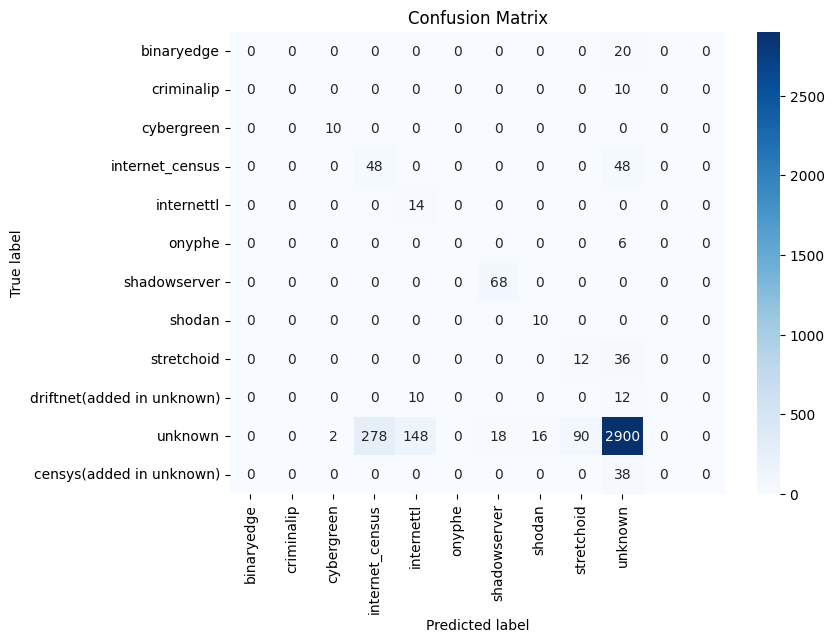

      prediction              ip  groundtruth            timestamp
0             25  167.99.227.103            4  2025-03-01 04:05:02
1             25     192.168.5.0            4  2025-03-01 04:05:02
2             25   50.116.53.243            4  2025-03-01 04:06:16
3             25     192.168.2.0            4  2025-03-01 04:06:16
4             25   45.79.151.251            4  2025-03-01 04:06:17
...          ...             ...          ...                  ...
3789          25     192.168.4.0           26  2025-03-03 15:43:38
3790          25    195.221.58.3           26  2025-03-03 15:43:39
3791          25     192.168.4.0           26  2025-03-03 15:43:39
3792          25     82.140.0.80           26  2025-03-03 15:50:38
3793          25     192.168.5.0           26  2025-03-03 15:50:38

[3794 rows x 4 columns]
Earliest time: 2025-02-25 16:00:00
Latest time: 2025-03-04 16:00:00
2025-02-25 16:00:00 2025-03-04 16:00:00
Segment 1 (2025-02-25 16:00:00 to 2025-03-04 16:00:00):
      p

/tmp/ipykernel_1239414/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


num_labels 2500 num_classes 25 this mode use all samples
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx [54 55 56 57 58 59 60 61 62 63]
idx_new [54 55 56 57 58 59 60 61 62 63]
samples_per_class 100 idx [64 65 66 67 68 69 70 71 72 73]
idx_new [64 65 66 67 68 69 70 71 72 73]
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx [102 103 104 105 106 107 108 109 110 111 112 113]
idx_new [102 103 104 105 106 107 108 109 110 111 112 113]
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx [114 115]
idx_new [114 115]
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []

100%|███████████████████████████████████████████| 17/17 [00:00<00:00, 49.95it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


y_true[closed_mask] [ 5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  9  9  9  9
  9  9  9  9  9  9  9  9 13 13 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 19 19 19 19 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20]
pred_hat_p[closed_mask] [20 20 20 20 20 20 20 20 20 20  6  6  6  6  6  6  6  6  6  6  9  9  9  9
  9  9  9  9  9  9  9  9 20 20 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 19 19 19 19 20 20

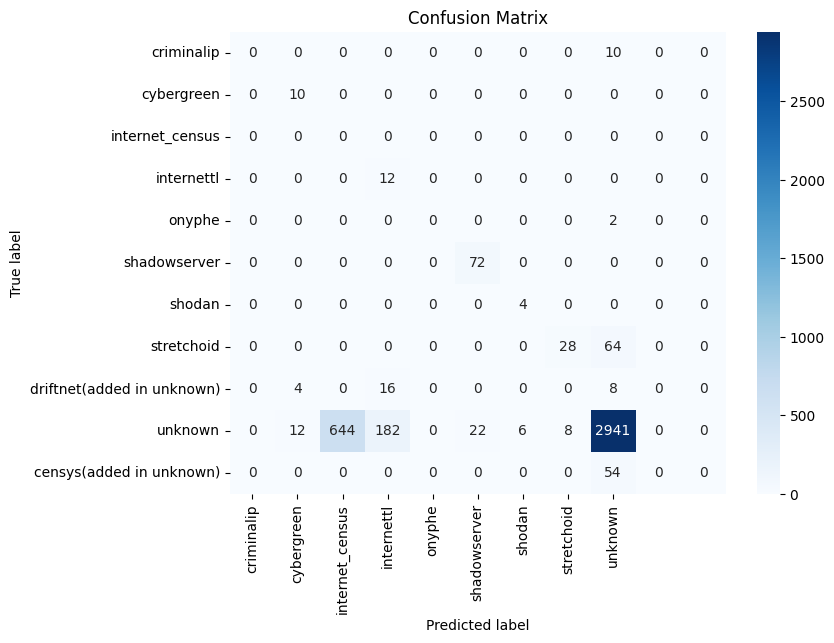

      prediction              ip  groundtruth            timestamp
0             25  206.168.34.171           27  2025-03-03 19:01:19
1             25     192.168.3.0           27  2025-03-03 19:01:19
2             25  167.94.138.158           27  2025-03-04 03:06:18
3             25     192.168.5.0           27  2025-03-04 03:06:18
4             25  206.168.34.160           27  2025-03-04 04:16:58
...          ...             ...          ...                  ...
4094          25     192.168.1.0           26  2025-03-10 15:40:05
4095          25    5.45.195.170           26  2025-03-10 15:46:55
4096          25     192.168.1.0           26  2025-03-10 15:46:55
4097           8     8.208.10.94           26  2025-03-10 15:48:47
4098           8     192.168.3.0           26  2025-03-10 15:48:47

[4099 rows x 4 columns]
Earliest time: 2025-03-04 16:00:00
Latest time: 2025-03-11 16:00:00
2025-03-04 16:00:00 2025-03-11 16:00:00
Segment 1 (2025-03-04 16:00:00 to 2025-03-11 16:00:00):
      p

In [9]:
dataset_name='SelfDeploy25'

from datetime import datetime, timedelta

def generate_date_range(start_date_str, end_date_str):
    start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
    end_date = datetime.strptime(end_date_str, '%Y-%m-%d')
    date_list = []
    current_date = start_date
    
    while current_date <= end_date:
        next_date = min(current_date + timedelta(days=7), end_date + timedelta(days=1))
        date_list.append((current_date.strftime('%Y-%m-%d'),next_date.strftime('%Y-%m-%d')))
        current_date = next_date
    return date_list

epoch_per_week=2
batch_size=32


if (dataset_name=='SelfDeploy24'):
    dataset='merge_month_2_4'
    start_date = '2024-02-01'    
    end_date = '2024-04-21'      
    ensemble_dir='train_ensemble_batch32_epoch2'
    
if (dataset_name=='SelfDeploy25'):
    dataset='selfdeploy_24_25_1week'
    start_date = '2024-12-10'  
    end_date = '2025-03-10'     
    ensemble_dir='train_ensemble_batch32_epoch2_selfdeploy25'

for protocol in ['http','tls','dns']:

    date_ranges = generate_date_range(start_date, end_date)
    
    print(date_ranges)
    for current_date_index in range(len(date_ranges)):
        start_date_str,end_date_str=date_ranges[current_date_index]
    
        print('start_date_str',start_date_str,'end_date_str',end_date_str)
    
    
        config_name=dataset+'_'+protocol+'_incre.yaml'
        save_name="iomatch_"+dataset+"_"+protocol+"_ep"+str(epoch_per_week)+"_bs"+str(batch_size)
        load_path="./saved_models/openset_cv/"+save_name+"/latest_model.pth"
        
        cmd1='rm data/'+dataset+'_'+protocol+'_openset/labeled_idx/*'
        print(cmd1)
        r1=os.system(cmd1)
        print(r1)
        args = parser.parse_args(args=['--c', 'config/openset_cv/iomatch/'+config_name])
        over_write_args_from_file(args, args.c)
        args.data_dir = 'data'
        args.load_path = load_path
        dataset_dict = get_dataset(args, args.algorithm, args.dataset,start_date_str, args.num_labels, args.num_classes, args.data_dir, eval_open=False)
        best_net = load_model_at(str((current_date_index+1)*epoch_per_week*100-1))
        eval_dict = evaluate_io(args, best_net, dataset_dict)
    
    
        import seaborn as sns
        import matplotlib.pyplot as plt
        from sklearn.metrics import confusion_matrix,classification_report
        
        label_list=eval_dict['label_list']
        #,'CriminalIP',
        labels=label_list
        
        labels_x=label_list[:-3]+['unknown']
        

        plt.figure(figsize=(8, 6))
        sns.heatmap(eval_dict['o_cfmat_f_q'], annot=True, cmap='Blues', fmt='g',xticklabels=labels_x,yticklabels=labels)#, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1']
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.title('Confusion Matrix')
        plt.show()
        

        value_to_delete = 26
        

        mask = eval_dict['y_true'] != value_to_delete
        filtered_y_true = eval_dict['y_true'][mask]
        filtered_pred_q = eval_dict['pred_q'][mask]
        filtered_y_true[filtered_y_true >25]=25
        
        #report=classification_report(filtered_y_true,filtered_pred_q,target_names=label_list[:-3]+['driftnet+censys(added in unknown)'])
        #print(report)
    
        import numpy as np
        import pandas as pd
        import pickle
        

        if('http' in config_name):
            proto='http'
        if('tls' in config_name):
            proto='tls'
        if('dns' in config_name):
            proto='dns'
        if('ssh' in config_name):
            proto='ssh'
        if('rdp' in config_name):
            proto='rdp'
            
        name=dataset
        if (dataset_name=='SelfDeploy24'):
            mode='incre'
        else:
            mode=''
        npy_path1 = '../dataset/npy/ip_array_'+proto+'_'+name+'_'+mode+'_'+start_date_str+'.npy'
        #npy_path1 = 'ip_array_'+proto+'_'+name+'_'+mode+'.npy'
        npy_path2 = '../dataset/npy/timestamp_'+proto+'_'+name+'_'+mode+'_'+start_date_str+'.npy'
        #dataset = NumpyDataset(npy_path1,npy_path2)
        
        loaded_array = np.load(npy_path1,allow_pickle=True)
        loaded_array
        len(loaded_array)
        loaded_timestamp = np.load(npy_path2,allow_pickle=True)
        
        
        pred = eval_dict['pred_q']
        y_true = eval_dict['y_true']

        df = pd.DataFrame({'prediction': pred, 'ip': loaded_array,'groundtruth':y_true,'timestamp':loaded_timestamp})
        
        print(df)

        # A list of honeypot IP addresses to remove
        ips_to_remove = ['192.168.1.0', '192.168.2.0','192.168.3.0','192.168.4.0','192.168.5.0']
        
        # Removes the row with the specified IP address
        df = df[~df['ip'].isin(ips_to_remove)]
        
            
        
        df.to_csv('result_'+proto+'_'+name+'_'+mode+'_'+start_date_str+'.csv', index=False)
        
        
        
        for day_interval in [7]:
        

            df = pd.read_csv('result_'+proto+'_'+name+'_'+mode+'_'+start_date_str+'.csv')
            

            df['timestamp'] = pd.to_datetime(df['timestamp'])
            

            earliest_time = pd.to_datetime(start_date_str+' 16:00:00') #df['timestamp'].min()
            latest_time = pd.to_datetime(end_date_str+' 16:00:00')#df['timestamp'].max()
            
            print(f"Earliest time: {earliest_time}")
            print(f"Latest time: {latest_time}")
            

            time_range = latest_time - earliest_time
            

            num_segments = (time_range.days) // day_interval 
            if(num_segments==0):
                num_segments+=1
            

            segment_dfs = []
            

            for i in range(num_segments):
                start_time = earliest_time + pd.Timedelta(days=i * day_interval)
                end_time = earliest_time + pd.Timedelta(days=(i + 1) * day_interval)
                print(start_time,end_time)
  
                segment_df = df[(df['timestamp'] >= start_time) & (df['timestamp'] < end_time)]
                

                segment_dfs.append(segment_df)
            
            for i, segment_df in enumerate(segment_dfs):
                start_time = earliest_time + pd.Timedelta(days=i * day_interval)
                end_time = earliest_time + pd.Timedelta(days=(i + 1) * day_interval)
                print(f"Segment {i+1} ({start_time} to {end_time}):")
                print(segment_df)
                print("\n")
                
            file_dir=ensemble_dir+'/result_'+str(day_interval)+'day_segment_'+proto+'_'+start_date_str+'/'
            import os
            

            directory = file_dir
            
            if not os.path.exists(directory):
                os.mkdir(directory)
                print(f"Directory '{directory}' created.")
            else:
                print(f"Directory '{directory}' already exists.")
                
            for i, segment_df in enumerate(segment_dfs):
                segment_df.to_csv(ensemble_dir+'/result_'+str(day_interval)+'day_segment_'+proto+'_'+start_date_str+f'/segment_{i+1}.csv', index=False)
            
            #The most common of the predicted label is calculated for each ip
            def protocol_level_prediciton(ip_train2,y_train2,train2_label_dic_common):
                a=pd.DataFrame()
                a['ip']=ip_train2
                a['label']=y_train2
                a['pred_label']=None
                a=a.drop_duplicates()
                for index, row in a.iterrows():
                    #print(index,train2_label_dic_common[row['ip']])
                    #a.loc[index,'pred_label']=1
                    a.loc[index,'pred_label']=train2_label_dic_common[row['ip']]
                #print(a)
                return a
            
            import os
            import pandas as pd
            
            folder_path = ensemble_dir+'/result_'+str(day_interval)+'day_segment_'+proto+'_'+start_date_str
            
            files = [f for f in os.listdir(folder_path) if f.startswith('seg') and f.endswith('.csv')]
            
            dfs = []
            
            for file in files:
                file_path = os.path.join(folder_path, file)
                df = pd.read_csv(file_path)
                dfs.append(df)
            
            dfs_merge_protocol_level={}
            for i, df in enumerate(dfs):
                print(f"DataFrame from {files[i]}:")

                test_http_label_dic = {}
                for value, group_df in df.groupby('ip'):
                    test_http_label_dic[value] = group_df
                    
                test_http_label_dic_common={}
                for j in test_http_label_dic.keys():
                    test_http_label_dic_common[j]=test_http_label_dic[j]['prediction'].mode().values[0]
                
                df_ip_http_test=protocol_level_prediciton(df['ip'],df['groundtruth'],test_http_label_dic_common)
                df_ip_http_test=df_ip_http_test.rename(columns={'pred_label':'pred_label_'+proto})
                dfs_merge_protocol_level[files[i]]=df_ip_http_test

                print(dfs_merge_protocol_level)
                
            with open('proto_level_'+str(day_interval)+'daysegment_pred_'+proto+'_'+name+'_'+mode+'_'+start_date_str+'.pkl', 'wb') as f:
                pickle.dump(dfs_merge_protocol_level, f)
             
            dfs_merge_protocol_level